*Last updated: 23 June 2022*

# Telecom Customer Churn

This dataset comes from an Iranian telecom company, with each row representing a customer over a year period. Along with a churn label, there is information on the customers' activity, such as call failures and subscription length. 

## Data Dictionary
| Column                  | Explanation                                             |
|-------------------------|---------------------------------------------------------|
| Call Failure            | number of call failures                                 |
| Complains               | binary (0: No complaint, 1: complaint)                  |
| Subscription Length     | total months of subscription                            |
| Charge Amount           | ordinal attribute (0: lowest amount, 9: highest amount) |
| Seconds of Use          | total seconds of calls                                  |
| Frequency of use        | total number of calls                                   |
| Frequency of SMS        | total number of text messages                           |
| Distinct Called Numbers | total number of distinct phone calls                    |
| Age Group               | ordinal attribute (1: younger age, 5: older age)        |
| Tariff Plan             | binary (1: Pay as you go, 2: contractual)               |
| Status                  | binary (1: active, 2: non-active)                       |
| Age                     | age of customer                                         |
| Customer Value          | the calculated value of customer                        |
| Churn                   | class label (1: churn, 0: non-churn)                    |

[Source](https://www.kaggle.com/royjafari/customer-churn)  of dataset and [source](https://archive.ics.uci.edu/ml/datasets/Iranian+Churn+Dataset) of dataset description. 

**Citation**: Jafari-Marandi, R., Denton, J., Idris, A., Smith, B. K., & Keramati, A. (2020). Optimum Profit-Driven Churn Decision Making: Innovative Artificial Neural Networks in Telecom Industry. Neural Computing and Applications.

## Motivation for the analysis

The motivation for this notebook was to apply what I had learned about survival analysis by following through the `lifelines` documentation (https://lifelines.readthedocs.io/en/latest/). Traditionally, this type of analysis was developed to measure the lifespans of individuals, but is now an entire branch of statistics aimed at analysing time to an event. In this case, it's time to churn as measured by subscription length.

Survival analysis can be used to:
- calculate the proportion of individuals that will experience the event
- estimate the time until event/failure in a population
- calculate the rate of the event in a population
- explore what factors increase or decrease survival
- predict the probability of event occurrence for an individual.

## An aside: Data preprocessing

In [1]:
%%capture
!pip install lifelines

In [2]:
# import all necessary libraries
import lifelines
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lifelines import *
from lifelines.calibration import survival_probability_calibration
from lifelines.datasets import load_diabetes
from lifelines.plotting import add_at_risk_counts, plot_interval_censored_lifetimes, plot_lifetimes, qq_plot
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines.utils import find_best_parametric_model

In [3]:
# import the data
df = pd.read_csv("data/customer_churn.csv")

# remove spaces in column names
df.columns = df.columns.str.replace(' ', '')

# rename selected columns
df.rename(columns = {
    'Frequencyofuse': 'FrequencyofUse'
}, inplace = True)

df.head()

,CallFailure,Complains,SubscriptionLength,ChargeAmount,SecondsofUse,FrequencyofUse,FrequencyofSMS,DistinctCalledNumbers,AgeGroup,TariffPlan,Status,Age,CustomerValue,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


In [4]:
surv_df = df

### Cardinality reduction

In [5]:
# consolidate Charge Amount categories
surv_df['ChargeAmount2'] = surv_df.ChargeAmount.apply(lambda x: x if x < 4 else 4)

In [6]:
# dicretise continuous numeric variables
surv_df['CallFailureGroup'] = pd.cut(surv_df.CallFailure, bins = [-10,5,10,15,20,40], labels = False)
surv_df['SecsofUseGroup'] = pd.cut(surv_df.SecondsofUse, bins = [-10,2500,5000,10000,20000], labels = False)
surv_df['FreqofUseGroup'] = pd.cut(surv_df.FrequencyofUse, bins = [-10,25,50,75,100,300], labels = False)
surv_df['FreqofSMSGroup'] = pd.cut(surv_df.FrequencyofSMS, bins = [-10,25,50,550], labels = False)
surv_df['DistinctCalledNumsGroup'] = pd.cut(surv_df.DistinctCalledNumbers, bins = [-10,10,20,30,40,100], labels = False)
surv_df['CustomerValueGroup'] = pd.cut(surv_df.CustomerValue, bins = [-10,250,500,1000,1500,2500], labels = False)

In [7]:
surv_df.head()

,CallFailure,Complains,SubscriptionLength,ChargeAmount,SecondsofUse,FrequencyofUse,FrequencyofSMS,DistinctCalledNumbers,AgeGroup,TariffPlan,...,Age,CustomerValue,Churn,ChargeAmount2,CallFailureGroup,SecsofUseGroup,FreqofUseGroup,FreqofSMSGroup,DistinctCalledNumsGroup,CustomerValueGroup
0,8,0,38,0,4370,71,5,17,3,1,...,30,197.640,0,0,1,1,2,0,1,0
1,0,0,39,0,318,5,7,4,2,1,...,25,46.035,0,0,0,0,0,0,0,0
2,10,0,37,0,2453,60,359,24,3,1,...,30,1536.520,0,0,1,0,2,2,2,4
3,10,0,38,0,4198,66,1,35,1,1,...,15,240.020,0,0,1,1,2,0,3,0
4,3,0,38,0,2393,58,2,33,1,1,...,15,145.805,0,0,0,0,2,0,3,0


## A little bit about censoring

Censoring refers to the situation in which survival time is only partially known. All individuals/observations that have not been subject to the "death" event - have not churned - during the observation period are considered to be **right-censored**.

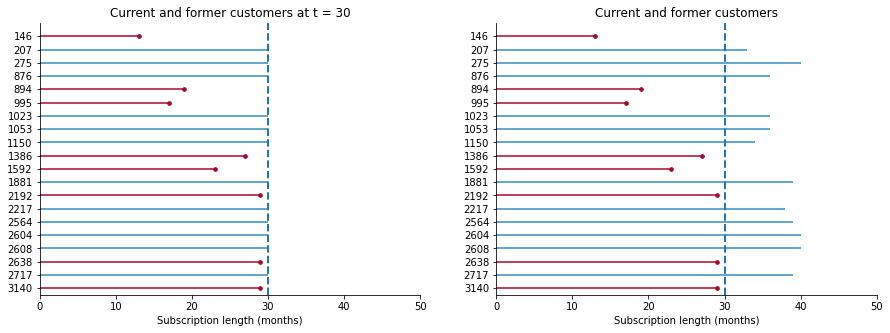

In [8]:
df_sub = df.sample(n = 20).sort_index(ascending = False)

CURRENT_TIME = 30
actual_lifetimes = df_sub.SubscriptionLength
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME

fig, axs = plt.subplots(1,2, figsize = (15,5))

plot_lifetimes(observed_lifetimes, event_observed = death_observed, sort_by_duration = False, ax = axs[0])
axs[0].set_title("Current and former customers at t = 30")
plot_lifetimes(actual_lifetimes, event_observed = death_observed, sort_by_duration = False, ax = axs[1])
axs[1].set_title("Current and former customers")

for col in range(2):
    axs[col].axvline(30, 0, 50, lw = 2, linestyle = "--")
    axs[col].set_xlim(0, 50)
    axs[col].set_xlabel("Subscription length (months)")
    axs[col].spines['right'].set_visible(False)
    axs[col].spines['top'].set_visible(False)

A common mistake often made by data analysts is to ignore right-censored individuals. This can be a mistake. In the figures above, the red lines denote a sample of customers that have churned during the observation period and the blue lines denote customers that are still customers of the telecommunications company (20 in total). The vertical line denotes an arbitrarily chosen cut-off point for observation of the churn status of customers.

If an analyst wanted to calculate the average length of a subscription with the company and naively decided to ignore all the blue individuals, then they'd clearly underestimate this value. However, even if these individuals were included in the calculation, it would still be an underestimation of the true average length of subscription. This is because when those customers eventually churned was unknown at the time of the analysis ($t = 30$).

Survival analysis was originally developed to solve this type of problem; that is, estimation in the presence of right-censored data.

As you might have suspected, right-censoring is not the only type of censoring but it is the most common. **Left-censoring** occurs when the "birth" event is not observed. For example, in this context it would mean the company is unsure as to when the customer signed up. For a less nonsensical example, it could be when someone goes to the doctor because they are sick. The doctor can't be sure as to when exactly the person contracted the illness, but knows for certain it was before the person visited his/her practice. Left-censoring also occurs when the event magnitude goes beyond a measurement instrument's upper bound; for example, flood waters going higher than the wooden sticks sometimes seen at the side of a road.

**Interval censoring** occurs when the death or birth event is known to have occurred between two time periods, but again is not known exactly. For example, consider a situation in which a sensor records the status of an event at regular 5-minute intervals rather than monitoring continuously. The sensor would record that an individual "died" between time $t$ and time $t + 5$, but was unable to record if it was at $t + 1$, $t + 2$, $t + 3$, $t + 4$ or indeed $t + 5$.

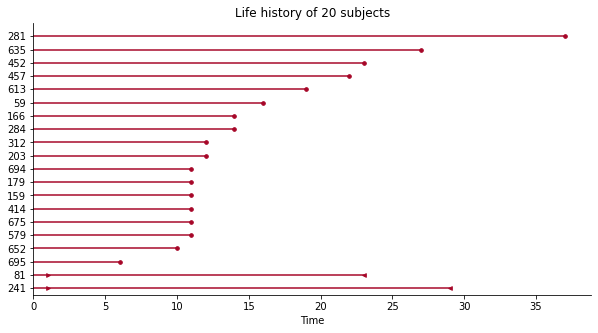

In [9]:
diabetes_df = load_diabetes()
diabetes_df_sub = diabetes_df.sample(n = 20)

fig, ax = plt.subplots(figsize = (10,5))

plot_interval_censored_lifetimes(diabetes_df_sub['left'], diabetes_df_sub['right'])
plt.xlabel("Time")
plt.title("Life history of 20 subjects")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

If the subject's exact time of death was known, it's denoted by a red dot. If it's interval censored, the time interval is bounded by two red arrows.

## Survival Function

If T is a (possibly infinite, but always non-negative) random lifetime taken from the population under study, then the survival function - $S(t)$ - of a population is defined as: 

$$S(t) = Pr(T > t)$$

where:

1. $0 \le S(t) \le 1$
2. $F_T(t) = 1 - S(t)$, where $F(t)$ is the CDF of $T$, which implies
3. $S(t)$ is a non-increasing function of (t).

In other words, the survival function defines the probability that the death event hasn't occurred yet at time $t$ or equivalently, the probability of surviving past time $t$.

### Kaplan-Meier Estimator

This is a non-parametric statistic that estimates the survival function of time-to-event data and tends to be one of the first models applied to time-to-event data. For those that need a reminder, a non-parametric statistic is one that constructs a survival curve from the data and doesn't assume a particular underlying distribution. It's also known as the product-limit or K-M estimator and is defined as: 

$$S(t) = \prod_{t_i < t} 1 - \frac{d_i}{n_i} $$

where:
- $t$ - a duration time
- $d$ - number of events that happened at time $t$
- $n$ - number of individuals known to have survived up to time $t$

Note that the estimator makes three assumptions:
1. Unambiguous events - The death event occurs at a clearly specified time.
2. Survival probabilities are comparable for all subjects - Individuals' survival probabilities do not depend on when they entered the dataset.
3. Censorship is non-informative - Censored observations have the same survival prospects as observations that don't continue to be followed.

However, whilst it provides an intuitive interpretation of survival probabilities and is a flexible method, it can't provide a median survival time if more than 50% of the data is censored.

Let's now go back to the telco data...

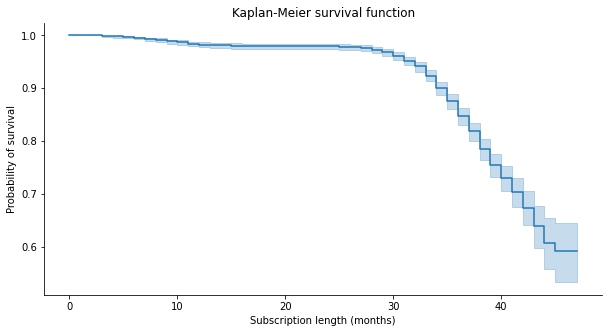

In [10]:
kmf = KaplanMeierFitter()
kmf.fit(durations = surv_df.SubscriptionLength, event_observed = surv_df.Churn)

fig, ax = plt.subplots(figsize = (10,5))
kmf.plot_survival_function(ax = ax)
plt.xlabel("Subscription length (months)")
plt.ylabel("Probability of survival")
plt.title("Kaplan-Meier survival function")
ax.legend_.remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

This plot suggests that customers have a high chance of staying up to a subscription length of about 30 months, but the probability of churning increases rapidly thereafter.

In [11]:
# plot covariate set-up
complains = (surv_df.Complains == 1)
tariff = (surv_df.TariffPlan == 1)
status = (surv_df.Status == 1)

agegrp_dict = {}
for grp in surv_df.AgeGroup.unique():
    key = str('age_group' + str(grp))
    agegrp_dict[key] = (surv_df.AgeGroup == grp)
    
chargeamt_dict = {}
for grp in surv_df.ChargeAmount2.unique():
    key = str('charge_amt' + str(grp))
    chargeamt_dict[key] = (surv_df.ChargeAmount2 == grp)
    
callfailure_dict = {}
for grp in surv_df.CallFailureGroup.unique():
    key = str('call_failure' + str(grp))
    callfailure_dict[key] = (surv_df.CallFailureGroup == grp)
    
sou_dict = {}
for grp in surv_df.SecsofUseGroup.unique():
    key = str('sou' + str(grp))
    sou_dict[key] = (surv_df.SecsofUseGroup == grp)
    
fou_dict = {}
for grp in surv_df.FreqofUseGroup.unique():
    key = str('fou' + str(grp))
    fou_dict[key] = (surv_df.FreqofUseGroup == grp)
    
fosms_dict = {}
for grp in surv_df.FreqofSMSGroup.unique():
    key = str('fosms' + str(grp))
    fosms_dict[key] = (surv_df.FreqofSMSGroup == grp)
    
distinctnums_dict = {}
for grp in surv_df.DistinctCalledNumsGroup.unique():
    key = str('distinct_nums' + str(grp))
    distinctnums_dict[key] = (surv_df.DistinctCalledNumsGroup == grp)
    
customervalue_dict = {}
for grp in surv_df.CustomerValueGroup.unique():
    key = str('cust_value' + str(grp))
    customervalue_dict[key] = (surv_df.CustomerValueGroup == grp)

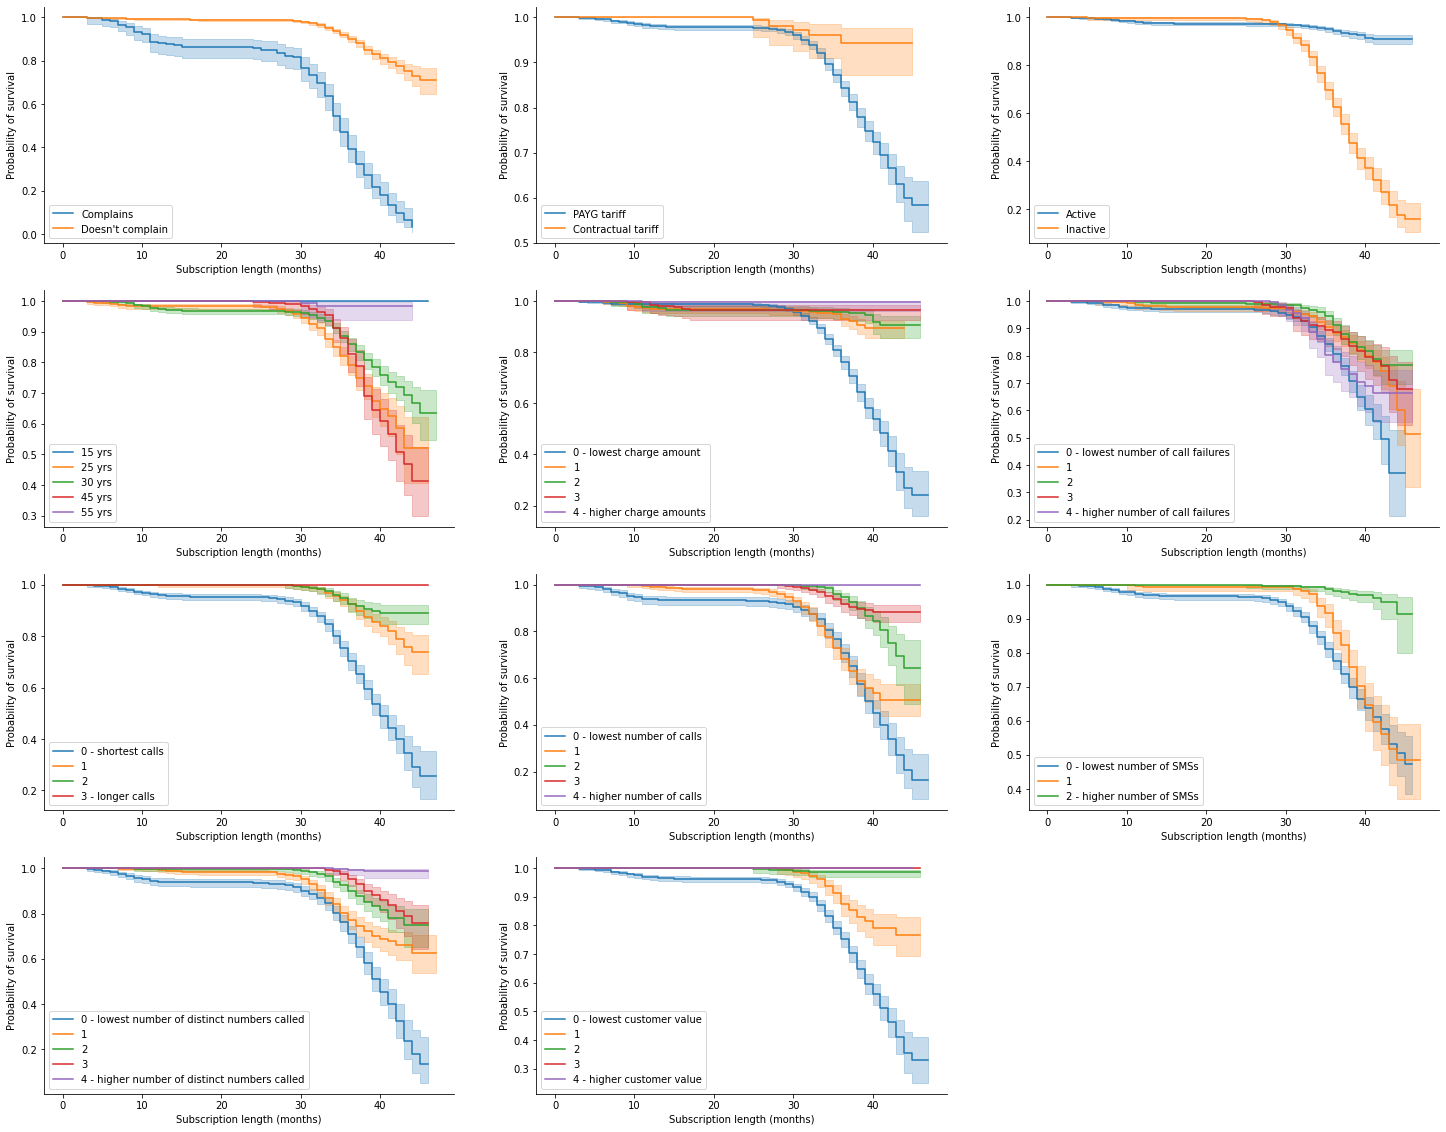

In [12]:
# set the plot dimensions
nrow = 4
ncol = 3

fig, axs = plt.subplots(nrow,ncol, figsize = (25,20))

kmf = KaplanMeierFitter()
kmf.fit(durations = df.SubscriptionLength[complains], event_observed = df.Churn[complains], label = "Complains").plot_survival_function(ax = axs[0,0])
kmf.fit(durations = df.SubscriptionLength[~complains], event_observed = df.Churn[~complains], label = "Doesn't complain").plot_survival_function(ax = axs[0,0])

kmf = KaplanMeierFitter()
kmf.fit(durations = df.SubscriptionLength[tariff], event_observed = df.Churn[tariff], label = "PAYG tariff").plot_survival_function(ax = axs[0,1])
kmf.fit(durations = df.SubscriptionLength[~tariff], event_observed = df.Churn[~tariff], label = "Contractual tariff").plot_survival_function(ax = axs[0,1])

kmf = KaplanMeierFitter()
kmf.fit(durations = df.SubscriptionLength[status], event_observed = df.Churn[status], label = "Active").plot_survival_function(ax = axs[0,2])
kmf.fit(durations = df.SubscriptionLength[~status], event_observed = df.Churn[~status], label = "Inactive").plot_survival_function(ax = axs[0,2])

kmf = KaplanMeierFitter()
kmf.fit(durations = df.SubscriptionLength[agegrp_dict['age_group1']], event_observed = df.Churn[agegrp_dict['age_group1']], label = "15 yrs").plot_survival_function(ax = axs[1,0])
kmf.fit(durations = df.SubscriptionLength[agegrp_dict['age_group2']], event_observed = df.Churn[agegrp_dict['age_group2']], label = "25 yrs").plot_survival_function(ax = axs[1,0])
kmf.fit(durations = df.SubscriptionLength[agegrp_dict['age_group3']], event_observed = df.Churn[agegrp_dict['age_group3']], label = "30 yrs").plot_survival_function(ax = axs[1,0])
kmf.fit(durations = df.SubscriptionLength[agegrp_dict['age_group4']], event_observed = df.Churn[agegrp_dict['age_group4']], label = "45 yrs").plot_survival_function(ax = axs[1,0])
kmf.fit(durations = df.SubscriptionLength[agegrp_dict['age_group5']], event_observed = df.Churn[agegrp_dict['age_group5']], label = "55 yrs").plot_survival_function(ax = axs[1,0])

kmf = KaplanMeierFitter()
kmf.fit(durations = df.SubscriptionLength[chargeamt_dict['charge_amt0']], event_observed = df.Churn[chargeamt_dict['charge_amt0']], 
        label = "0 - lowest charge amount").plot_survival_function(ax = axs[1,1])
kmf.fit(durations = df.SubscriptionLength[chargeamt_dict['charge_amt1']], event_observed = df.Churn[chargeamt_dict['charge_amt1']], 
        label = "1").plot_survival_function(ax = axs[1,1])
kmf.fit(durations = df.SubscriptionLength[chargeamt_dict['charge_amt2']], event_observed = df.Churn[chargeamt_dict['charge_amt2']], 
        label = "2").plot_survival_function(ax = axs[1,1])
kmf.fit(durations = df.SubscriptionLength[chargeamt_dict['charge_amt3']], event_observed = df.Churn[chargeamt_dict['charge_amt3']], 
        label = "3").plot_survival_function(ax = axs[1,1])
kmf.fit(durations = df.SubscriptionLength[chargeamt_dict['charge_amt4']], event_observed = df.Churn[chargeamt_dict['charge_amt4']], 
        label = "4 - higher charge amounts").plot_survival_function(ax = axs[1,1])

kmf = KaplanMeierFitter()
kmf.fit(durations = df.SubscriptionLength[callfailure_dict['call_failure0']], event_observed = df.Churn[callfailure_dict['call_failure0']], 
        label = "0 - lowest number of call failures").plot_survival_function(ax = axs[1,2])
kmf.fit(durations = df.SubscriptionLength[callfailure_dict['call_failure1']], event_observed = df.Churn[callfailure_dict['call_failure1']], 
        label = "1").plot_survival_function(ax = axs[1,2])
kmf.fit(durations = df.SubscriptionLength[callfailure_dict['call_failure2']], event_observed = df.Churn[callfailure_dict['call_failure2']], 
        label = "2").plot_survival_function(ax = axs[1,2])
kmf.fit(durations = df.SubscriptionLength[callfailure_dict['call_failure3']], event_observed = df.Churn[callfailure_dict['call_failure3']], 
        label = "3").plot_survival_function(ax = axs[1,2])
kmf.fit(durations = df.SubscriptionLength[callfailure_dict['call_failure4']], event_observed = df.Churn[callfailure_dict['call_failure4']], 
        label = "4 - higher number of call failures").plot_survival_function(ax = axs[1,2])

kmf = KaplanMeierFitter()
kmf.fit(durations = df.SubscriptionLength[sou_dict['sou0']], event_observed = df.Churn[sou_dict['sou0']], label = "0 - shortest calls").plot_survival_function(ax = axs[2,0])
kmf.fit(durations = df.SubscriptionLength[sou_dict['sou1']], event_observed = df.Churn[sou_dict['sou1']], label = "1").plot_survival_function(ax = axs[2,0])
kmf.fit(durations = df.SubscriptionLength[sou_dict['sou2']], event_observed = df.Churn[sou_dict['sou2']], label = "2").plot_survival_function(ax = axs[2,0])
kmf.fit(durations = df.SubscriptionLength[sou_dict['sou3']], event_observed = df.Churn[sou_dict['sou3']], label = "3 - longer calls").plot_survival_function(ax = axs[2,0])

kmf = KaplanMeierFitter()
kmf.fit(durations = df.SubscriptionLength[fou_dict['fou0']], event_observed = df.Churn[fou_dict['fou0']], 
        label = "0 - lowest number of calls").plot_survival_function(ax = axs[2,1])
kmf.fit(durations = df.SubscriptionLength[fou_dict['fou1']], event_observed = df.Churn[fou_dict['fou1']], label = "1").plot_survival_function(ax = axs[2,1])
kmf.fit(durations = df.SubscriptionLength[fou_dict['fou2']], event_observed = df.Churn[fou_dict['fou2']], label = "2").plot_survival_function(ax = axs[2,1])
kmf.fit(durations = df.SubscriptionLength[fou_dict['fou3']], event_observed = df.Churn[fou_dict['fou3']], label = "3").plot_survival_function(ax = axs[2,1])
kmf.fit(durations = df.SubscriptionLength[fou_dict['fou4']], event_observed = df.Churn[fou_dict['fou4']], 
        label = "4 - higher number of calls").plot_survival_function(ax = axs[2,1])

kmf = KaplanMeierFitter()
kmf.fit(durations = df.SubscriptionLength[fosms_dict['fosms0']], event_observed = df.Churn[fosms_dict['fosms0']], 
        label = "0 - lowest number of SMSs").plot_survival_function(ax = axs[2,2])
kmf.fit(durations = df.SubscriptionLength[fosms_dict['fosms1']], event_observed = df.Churn[fosms_dict['fosms1']], label = "1").plot_survival_function(ax = axs[2,2])
kmf.fit(durations = df.SubscriptionLength[fosms_dict['fosms2']], event_observed = df.Churn[fosms_dict['fosms2']], 
        label = "2 - higher number of SMSs").plot_survival_function(ax = axs[2,2])

kmf = KaplanMeierFitter()
kmf.fit(durations = df.SubscriptionLength[distinctnums_dict['distinct_nums0']], event_observed = df.Churn[distinctnums_dict['distinct_nums0']], 
        label = "0 - lowest number of distinct numbers called").plot_survival_function(ax = axs[3,0])
kmf.fit(durations = df.SubscriptionLength[distinctnums_dict['distinct_nums1']], event_observed = df.Churn[distinctnums_dict['distinct_nums1']], 
        label = "1").plot_survival_function(ax = axs[3,0])
kmf.fit(durations = df.SubscriptionLength[distinctnums_dict['distinct_nums2']], event_observed = df.Churn[distinctnums_dict['distinct_nums2']], 
        label = "2").plot_survival_function(ax = axs[3,0])
kmf.fit(durations = df.SubscriptionLength[distinctnums_dict['distinct_nums3']], event_observed = df.Churn[distinctnums_dict['distinct_nums3']], 
        label = "3").plot_survival_function(ax = axs[3,0])
kmf.fit(durations = df.SubscriptionLength[distinctnums_dict['distinct_nums4']], event_observed = df.Churn[distinctnums_dict['distinct_nums4']], 
        label = "4 - higher number of distinct numbers called").plot_survival_function(ax = axs[3,0])

kmf = KaplanMeierFitter()
kmf.fit(durations = df.SubscriptionLength[customervalue_dict['cust_value0']], event_observed = df.Churn[customervalue_dict['cust_value0']], 
        label = "0 - lowest customer value").plot_survival_function(ax = axs[3,1])
kmf.fit(durations = df.SubscriptionLength[customervalue_dict['cust_value1']], event_observed = df.Churn[customervalue_dict['cust_value1']], 
        label = "1").plot_survival_function(ax = axs[3,1])
kmf.fit(durations = df.SubscriptionLength[customervalue_dict['cust_value2']], event_observed = df.Churn[customervalue_dict['cust_value2']], 
        label = "2").plot_survival_function(ax = axs[3,1])
kmf.fit(durations = df.SubscriptionLength[customervalue_dict['cust_value3']], event_observed = df.Churn[customervalue_dict['cust_value3']], 
        label = "3").plot_survival_function(ax = axs[3,1])
kmf.fit(durations = df.SubscriptionLength[customervalue_dict['cust_value4']], event_observed = df.Churn[customervalue_dict['cust_value4']], 
        label = "4 - higher customer value").plot_survival_function(ax = axs[3,1])

for row in range(nrow):
    for col in range(ncol):
        axs[row,col].set_xlabel("Subscription length (months)")
        axs[row,col].set_ylabel("Probability of survival")
        axs[row,col].spines['right'].set_visible(False)
        axs[row,col].spines['top'].set_visible(False)

# get rid of the last plot
# axs[3,2].set_axis_off()
fig.delaxes(ax = axs[3,2])

From these survival curves, it appears that those customers most likely to stay with the company past the 30-month mark:
- haven't complained
- on a contract
- an active customer
- in the youngest or oldest age bracket
- in anything but the lowest charging bracket
- make longer calls
- make more calls
- send more SMSs
- make a higher number of calls to different numbers
- have a higher customer value.

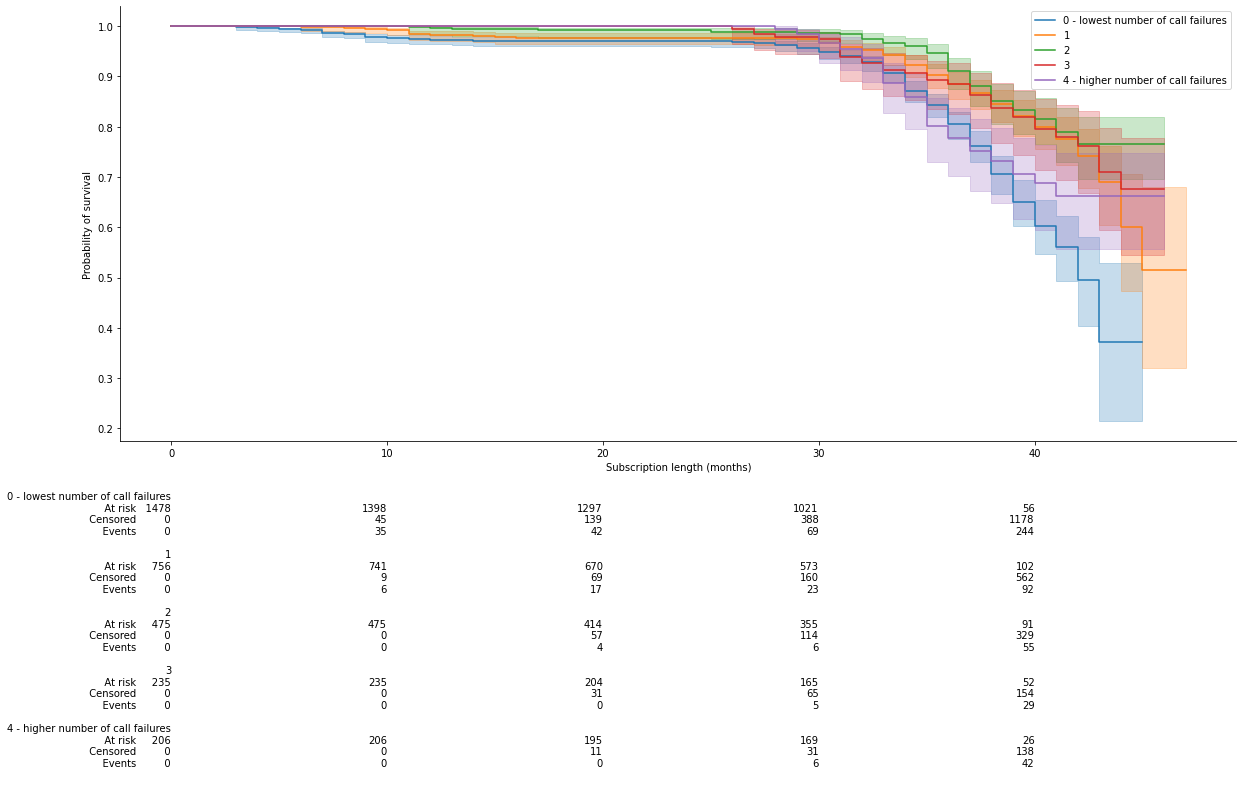

In [13]:
# adding counts to the bottom of the plot
plt.figure(figsize=(20,8))
ax = plt.subplot(1,1,1)

kmf0 = KaplanMeierFitter()
ax = kmf0.fit(durations = df.SubscriptionLength[callfailure_dict['call_failure0']], event_observed = df.Churn[callfailure_dict['call_failure0']], 
              label = "0 - lowest number of call failures").plot_survival_function(ax = ax)
kmf1 = KaplanMeierFitter()
ax = kmf1.fit(durations = df.SubscriptionLength[callfailure_dict['call_failure1']], event_observed = df.Churn[callfailure_dict['call_failure1']], 
              label = "1").plot_survival_function(ax = ax)
kmf2 = KaplanMeierFitter()
ax = kmf2.fit(durations = df.SubscriptionLength[callfailure_dict['call_failure2']], event_observed = df.Churn[callfailure_dict['call_failure2']], 
             label = "2").plot_survival_function(ax = ax)
kmf3 = KaplanMeierFitter()
ax = kmf3.fit(durations = df.SubscriptionLength[callfailure_dict['call_failure3']], event_observed = df.Churn[callfailure_dict['call_failure3']], 
             label = "3").plot_survival_function(ax = ax)
kmf4 = KaplanMeierFitter()
ax = kmf4.fit(durations = df.SubscriptionLength[callfailure_dict['call_failure4']], event_observed = df.Churn[callfailure_dict['call_failure4']], 
             label = "4 - higher number of call failures").plot_survival_function(ax = ax)

add_at_risk_counts(kmf0, kmf1, kmf2, kmf3, kmf4, ax=ax)
ax.set_xlabel("Subscription length (months)")
ax.set_ylabel("Probability of survival")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Logrank test

A logrank test is a common statistical test to compare two or more event series' generators. If the value returned exceeds a pre-specified critical value, then we conclude that the two series have different generators. The test has maximum power when the assumption of proportional hazards is true, which means that if the survival functions cross (as is the case for several covariates in this dataset), it may give an inaccurate assessment of differences.

(The proportional hazards assumption is that the ratio of the hazards (churn) for any two individuals is constant over time.

There are three options available: `logrank_test` applies when n = 2, `multivariate_logrank_test` is the equivalent test when n >= 2, and `pairwise_logrank_test` tests all pairwise combinations of a particular covariate. For the sake of brevity, this notebook demonstrates the first two only.

In [14]:
surv_df.head()

,CallFailure,Complains,SubscriptionLength,ChargeAmount,SecondsofUse,FrequencyofUse,FrequencyofSMS,DistinctCalledNumbers,AgeGroup,TariffPlan,...,Age,CustomerValue,Churn,ChargeAmount2,CallFailureGroup,SecsofUseGroup,FreqofUseGroup,FreqofSMSGroup,DistinctCalledNumsGroup,CustomerValueGroup
0,8,0,38,0,4370,71,5,17,3,1,...,30,197.640,0,0,1,1,2,0,1,0
1,0,0,39,0,318,5,7,4,2,1,...,25,46.035,0,0,0,0,0,0,0,0
2,10,0,37,0,2453,60,359,24,3,1,...,30,1536.520,0,0,1,0,2,2,2,4
3,10,0,38,0,4198,66,1,35,1,1,...,15,240.020,0,0,1,1,2,0,3,0
4,3,0,38,0,2393,58,2,33,1,1,...,15,145.805,0,0,0,0,2,0,3,0


In [15]:
covariates = ['Complains', 'AgeGroup', 'TariffPlan', 'Status', 'ChargeAmount2', 'CallFailureGroup', 'SecsofUseGroup', 'FreqofUseGroup', 'FreqofSMSGroup', 
              'DistinctCalledNumsGroup', 'CustomerValueGroup']

test_statistics = []
pvalues = []

# loop over the identified covariates and conduct a multivariate logrank test
for var in covariates:
    test = multivariate_logrank_test(event_durations = surv_df.SubscriptionLength, groups = surv_df[var], event_observed = surv_df.Churn, weightings = 'peto')
    # extract the test statistics and p-values to a list
    test_statistics.append(test.test_statistic)
    pvalues.append(test.p_value)

# construct a dictionary
dict = {'covariate': covariates, 'test_statistic': test_statistics, 'pvalue': pvalues}
# ...and convert it into a dataframe
logrank_df = pd.DataFrame(data = dict)

# define the significance level
conditions = [
    (logrank_df.pvalue.le(0.001)),
    (logrank_df.pvalue.gt(0.001) & logrank_df.pvalue.le(0.01)),
    (logrank_df.pvalue.gt(0.01) & logrank_df.pvalue.le(0.05)),
    (logrank_df.pvalue.gt(0.05) & logrank_df.pvalue.le(0.1)),
    (logrank_df.pvalue.gt(0.1)),
]
choices = ["***", "**", "*", ".", ""]

logrank_df["significance"] = np.select(conditions, choices)
logrank_df

,covariate,test_statistic,pvalue,significance
0,Complains,797.703223,1.703816e-175,***
1,AgeGroup,74.018613,3.213307e-15,***
2,TariffPlan,11.345082,7.564804e-04,***
3,Status,562.055901,3.001877e-124,***
4,ChargeAmount2,253.582825,1.100755e-53,***
5,CallFailureGroup,59.540650,3.622799e-12,***
6,SecsofUseGroup,396.186431,1.483172e-85,***
7,FreqofUseGroup,460.711213,2.099477e-98,***
8,FreqofSMSGroup,192.006410,2.024593e-42,***
9,DistinctCalledNumsGroup,331.171780,2.035166e-70,***


Unsurprisingly, we reject the null hypothesis and conclude that for every covariate, at least one of the generators is different from the others. If we wanted to investigate further and determine which were different, we'd use the `pairwise_logrank_test` function.

## Hazard Function

Survival functions are not the only way to visualise survival. Hazard functions are also possible, and these describe the probability that an event occurs at some time, given survival up to that particular point in time. Furthermore, the hazard rate is defined as the instantaneous rate of an event occurrence:

$$ h(t) = -\frac{d}{dt}logS(t) $$

And the cumulative hazard function - $H(t)$ - of a population is defined as:

$$H(t) = \int_0^t \lambda(z)\:dz $$ 

Two segues before we continue:

1. We care about the cumulative hazard even though it has a less intuitive understanding compared to the survival function is because it's the basis of more advanced techniques in survival analysis.
2. We care about the cumulative hazard over the hazard function (which is more interpretable) because we don't need to smooth out the differences.

### Nelson-Aalen Estimator

The estimator for the cumulative hazard function is called the Nelson-Aalen estimator:

$$ \hat{H}(t) = \sum_{t_i\,\le\,t}\frac{d_i}{n_i} $$

where:
- $d_i$ - number of deaths at time $t_i$
- $n_i$ - number of susceptible individuals

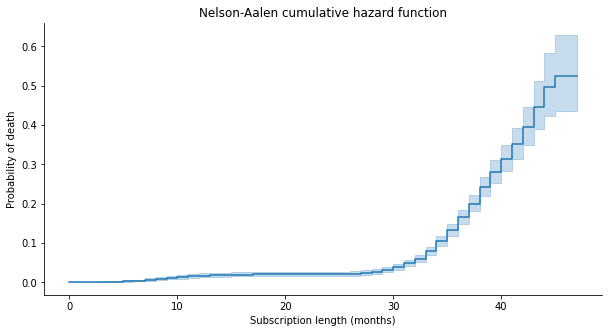

In [16]:
naf = NelsonAalenFitter()
naf.fit(durations = surv_df.SubscriptionLength, event_observed = surv_df.Churn)

fig, ax = plt.subplots(figsize = (10,5))
naf.plot_cumulative_hazard(ax = ax)
plt.xlabel("Subscription length (months)")
plt.ylabel("Probability of death")
plt.title("Nelson-Aalen cumulative hazard function")
ax.legend_.remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Consistent to what was observed previously, this plot indicates that customers have a low probability of churn until about the 30-month mark. We conclude this by examining the relative rates of change (or the slope) in the function as time increases, which start of very low and rapidly increase after $t = 30$.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


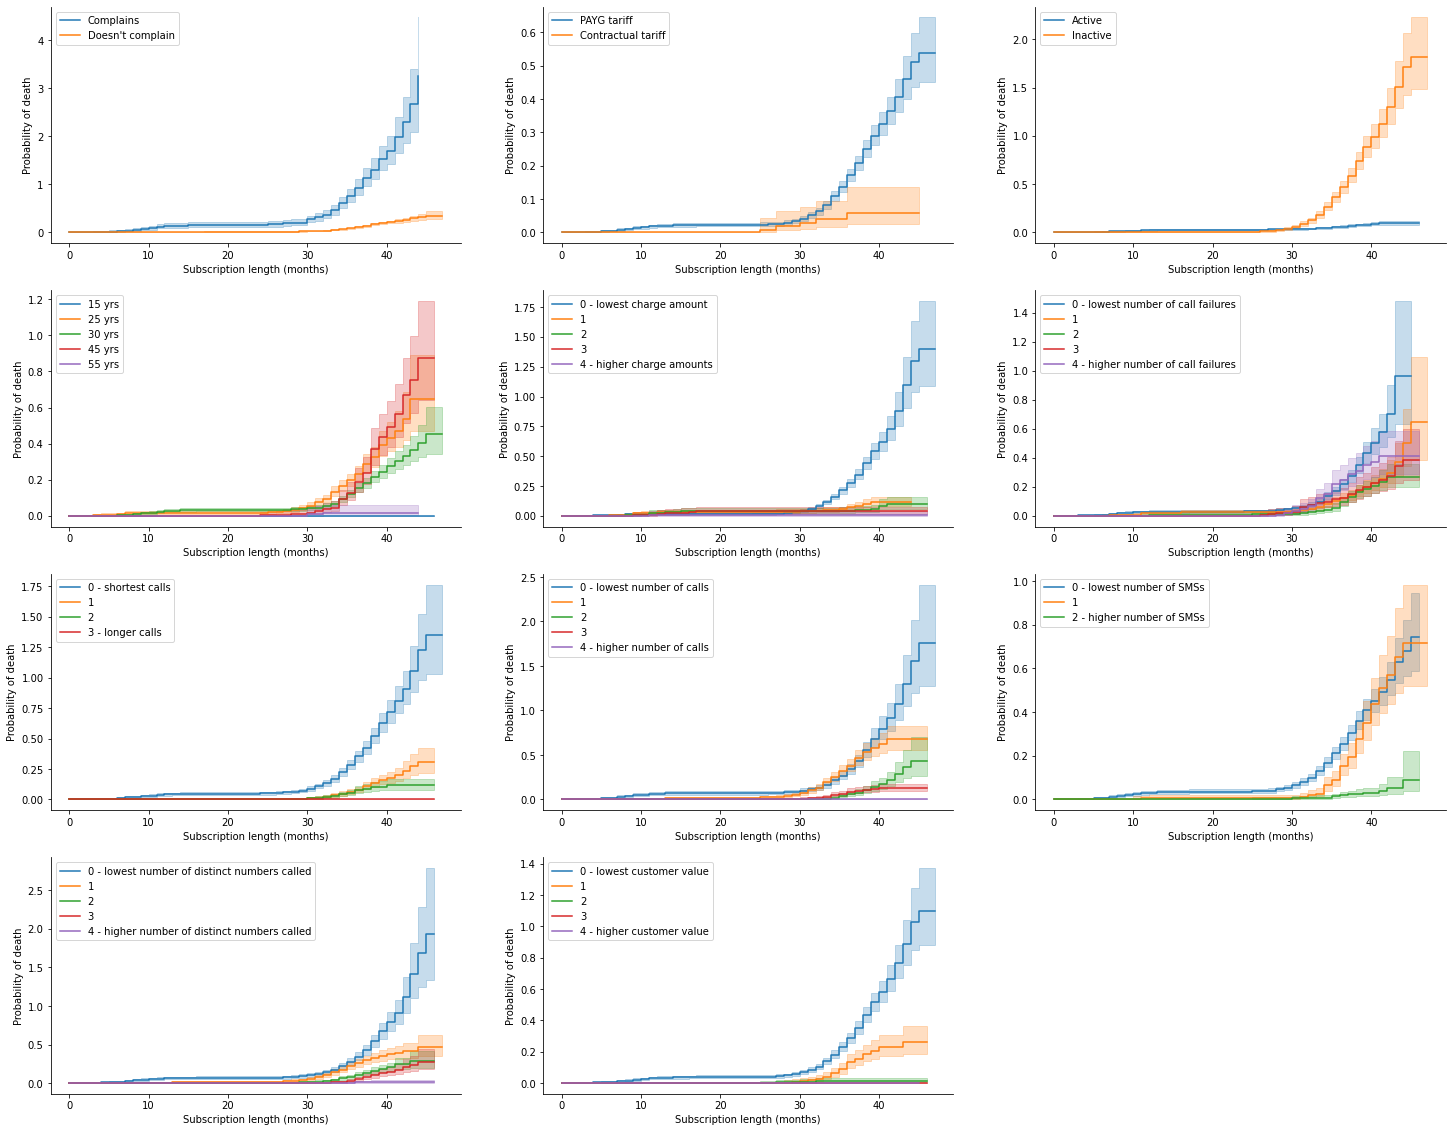

In [17]:
# set the plot dimensions
nrow = 4
ncol = 3

fig, axs = plt.subplots(nrow,ncol, figsize = (25,20))

naf = NelsonAalenFitter()
naf.fit(durations = df.SubscriptionLength[complains], event_observed = df.Churn[complains], label = "Complains").plot_cumulative_hazard(ax = axs[0,0])
naf.fit(durations = df.SubscriptionLength[~complains], event_observed = df.Churn[~complains], label = "Doesn't complain").plot_cumulative_hazard(ax = axs[0,0])

naf = NelsonAalenFitter()
naf.fit(durations = df.SubscriptionLength[tariff], event_observed = df.Churn[tariff], label = "PAYG tariff").plot_cumulative_hazard(ax = axs[0,1])
naf.fit(durations = df.SubscriptionLength[~tariff], event_observed = df.Churn[~tariff], label = "Contractual tariff").plot_cumulative_hazard(ax = axs[0,1])

naf = NelsonAalenFitter()
naf.fit(durations = df.SubscriptionLength[status], event_observed = df.Churn[status], label = "Active").plot_cumulative_hazard(ax = axs[0,2])
naf.fit(durations = df.SubscriptionLength[~status], event_observed = df.Churn[~status], label = "Inactive").plot_cumulative_hazard(ax = axs[0,2])

naf = NelsonAalenFitter()
naf.fit(durations = df.SubscriptionLength[agegrp_dict['age_group1']], event_observed = df.Churn[agegrp_dict['age_group1']], label = "15 yrs").plot_cumulative_hazard(ax = axs[1,0])
naf.fit(durations = df.SubscriptionLength[agegrp_dict['age_group2']], event_observed = df.Churn[agegrp_dict['age_group2']], label = "25 yrs").plot_cumulative_hazard(ax = axs[1,0])
naf.fit(durations = df.SubscriptionLength[agegrp_dict['age_group3']], event_observed = df.Churn[agegrp_dict['age_group3']], label = "30 yrs").plot_cumulative_hazard(ax = axs[1,0])
naf.fit(durations = df.SubscriptionLength[agegrp_dict['age_group4']], event_observed = df.Churn[agegrp_dict['age_group4']], label = "45 yrs").plot_cumulative_hazard(ax = axs[1,0])
naf.fit(durations = df.SubscriptionLength[agegrp_dict['age_group5']], event_observed = df.Churn[agegrp_dict['age_group5']], label = "55 yrs").plot_cumulative_hazard(ax = axs[1,0])

naf = NelsonAalenFitter()
naf.fit(durations = df.SubscriptionLength[chargeamt_dict['charge_amt0']], event_observed = df.Churn[chargeamt_dict['charge_amt0']], 
        label = "0 - lowest charge amount").plot_cumulative_hazard(ax = axs[1,1])
naf.fit(durations = df.SubscriptionLength[chargeamt_dict['charge_amt1']], event_observed = df.Churn[chargeamt_dict['charge_amt1']], 
        label = "1").plot_cumulative_hazard(ax = axs[1,1])
naf.fit(durations = df.SubscriptionLength[chargeamt_dict['charge_amt2']], event_observed = df.Churn[chargeamt_dict['charge_amt2']], 
        label = "2").plot_cumulative_hazard(ax = axs[1,1])
naf.fit(durations = df.SubscriptionLength[chargeamt_dict['charge_amt3']], event_observed = df.Churn[chargeamt_dict['charge_amt3']], 
        label = "3").plot_cumulative_hazard(ax = axs[1,1])
naf.fit(durations = df.SubscriptionLength[chargeamt_dict['charge_amt4']], event_observed = df.Churn[chargeamt_dict['charge_amt4']], 
        label = "4 - higher charge amounts").plot_cumulative_hazard(ax = axs[1,1])

naf = NelsonAalenFitter()
naf.fit(durations = df.SubscriptionLength[callfailure_dict['call_failure0']], event_observed = df.Churn[callfailure_dict['call_failure0']], 
        label = "0 - lowest number of call failures").plot_cumulative_hazard(ax = axs[1,2])
naf.fit(durations = df.SubscriptionLength[callfailure_dict['call_failure1']], event_observed = df.Churn[callfailure_dict['call_failure1']], 
        label = "1").plot_cumulative_hazard(ax = axs[1,2])
naf.fit(durations = df.SubscriptionLength[callfailure_dict['call_failure2']], event_observed = df.Churn[callfailure_dict['call_failure2']], 
        label = "2").plot_cumulative_hazard(ax = axs[1,2])
naf.fit(durations = df.SubscriptionLength[callfailure_dict['call_failure3']], event_observed = df.Churn[callfailure_dict['call_failure3']], 
        label = "3").plot_cumulative_hazard(ax = axs[1,2])
naf.fit(durations = df.SubscriptionLength[callfailure_dict['call_failure4']], event_observed = df.Churn[callfailure_dict['call_failure4']], 
        label = "4 - higher number of call failures").plot_cumulative_hazard(ax = axs[1,2])

naf = NelsonAalenFitter()
naf.fit(durations = df.SubscriptionLength[sou_dict['sou0']], event_observed = df.Churn[sou_dict['sou0']], label = "0 - shortest calls").plot_cumulative_hazard(ax = axs[2,0])
naf.fit(durations = df.SubscriptionLength[sou_dict['sou1']], event_observed = df.Churn[sou_dict['sou1']], label = "1").plot_cumulative_hazard(ax = axs[2,0])
naf.fit(durations = df.SubscriptionLength[sou_dict['sou2']], event_observed = df.Churn[sou_dict['sou2']], label = "2").plot_cumulative_hazard(ax = axs[2,0])
naf.fit(durations = df.SubscriptionLength[sou_dict['sou3']], event_observed = df.Churn[sou_dict['sou3']], label = "3 - longer calls").plot_cumulative_hazard(ax = axs[2,0])

naf = NelsonAalenFitter()
naf.fit(durations = df.SubscriptionLength[fou_dict['fou0']], event_observed = df.Churn[fou_dict['fou0']], 
        label = "0 - lowest number of calls").plot_cumulative_hazard(ax = axs[2,1])
naf.fit(durations = df.SubscriptionLength[fou_dict['fou1']], event_observed = df.Churn[fou_dict['fou1']], label = "1").plot_cumulative_hazard(ax = axs[2,1])
naf.fit(durations = df.SubscriptionLength[fou_dict['fou2']], event_observed = df.Churn[fou_dict['fou2']], label = "2").plot_cumulative_hazard(ax = axs[2,1])
naf.fit(durations = df.SubscriptionLength[fou_dict['fou3']], event_observed = df.Churn[fou_dict['fou3']], label = "3").plot_cumulative_hazard(ax = axs[2,1])
naf.fit(durations = df.SubscriptionLength[fou_dict['fou4']], event_observed = df.Churn[fou_dict['fou4']], 
        label = "4 - higher number of calls").plot_cumulative_hazard(ax = axs[2,1])

naf = NelsonAalenFitter()
naf.fit(durations = df.SubscriptionLength[fosms_dict['fosms0']], event_observed = df.Churn[fosms_dict['fosms0']], 
        label = "0 - lowest number of SMSs").plot_cumulative_hazard(ax = axs[2,2])
naf.fit(durations = df.SubscriptionLength[fosms_dict['fosms1']], event_observed = df.Churn[fosms_dict['fosms1']], label = "1").plot_cumulative_hazard(ax = axs[2,2])
naf.fit(durations = df.SubscriptionLength[fosms_dict['fosms2']], event_observed = df.Churn[fosms_dict['fosms2']], 
        label = "2 - higher number of SMSs").plot_cumulative_hazard(ax = axs[2,2])

naf = NelsonAalenFitter()
naf.fit(durations = df.SubscriptionLength[distinctnums_dict['distinct_nums0']], event_observed = df.Churn[distinctnums_dict['distinct_nums0']], 
        label = "0 - lowest number of distinct numbers called").plot_cumulative_hazard(ax = axs[3,0])
naf.fit(durations = df.SubscriptionLength[distinctnums_dict['distinct_nums1']], event_observed = df.Churn[distinctnums_dict['distinct_nums1']], 
        label = "1").plot_cumulative_hazard(ax = axs[3,0])
naf.fit(durations = df.SubscriptionLength[distinctnums_dict['distinct_nums2']], event_observed = df.Churn[distinctnums_dict['distinct_nums2']], 
        label = "2").plot_cumulative_hazard(ax = axs[3,0])
naf.fit(durations = df.SubscriptionLength[distinctnums_dict['distinct_nums3']], event_observed = df.Churn[distinctnums_dict['distinct_nums3']], 
        label = "3").plot_cumulative_hazard(ax = axs[3,0])
naf.fit(durations = df.SubscriptionLength[distinctnums_dict['distinct_nums4']], event_observed = df.Churn[distinctnums_dict['distinct_nums4']], 
        label = "4 - higher number of distinct numbers called").plot_cumulative_hazard(ax = axs[3,0])

naf = NelsonAalenFitter()
naf.fit(durations = df.SubscriptionLength[customervalue_dict['cust_value0']], event_observed = df.Churn[customervalue_dict['cust_value0']], 
        label = "0 - lowest customer value").plot_cumulative_hazard(ax = axs[3,1])
naf.fit(durations = df.SubscriptionLength[customervalue_dict['cust_value1']], event_observed = df.Churn[customervalue_dict['cust_value1']], 
        label = "1").plot_cumulative_hazard(ax = axs[3,1])
naf.fit(durations = df.SubscriptionLength[customervalue_dict['cust_value2']], event_observed = df.Churn[customervalue_dict['cust_value2']], 
        label = "2").plot_cumulative_hazard(ax = axs[3,1])
naf.fit(durations = df.SubscriptionLength[customervalue_dict['cust_value3']], event_observed = df.Churn[customervalue_dict['cust_value3']], 
        label = "3").plot_cumulative_hazard(ax = axs[3,1])
naf.fit(durations = df.SubscriptionLength[customervalue_dict['cust_value4']], event_observed = df.Churn[customervalue_dict['cust_value4']], 
        label = "4 - higher customer value").plot_cumulative_hazard(ax = axs[3,1])

for row in range(nrow):
    for col in range(ncol):
        axs[row,col].set_xlabel("Subscription length (months)")
        axs[row,col].set_ylabel("Probability of death")
        axs[row,col].legend(loc = 'upper left')
        axs[row,col].spines['right'].set_visible(False)
        axs[row,col].spines['top'].set_visible(False)

# get rid of the last plot
# axs[3,2].set_axis_off()
fig.delaxes(ax = axs[3,2])

Note that you can derive and plot the hazard function rather than the cumulative hazard, but (at least for this package) involves using a kernel smoother to smooth out the differences in the cumulative hazard function and hence a bandwidth parameter to specify the desired amount of smoothing. Furthermore, there's a fair amount of trial and error involved to pick an appropriate amount of smoothing, and the choice of value can affect the interpretation so the author of the lifelines package recommended sticking with the cumulative hazard function.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


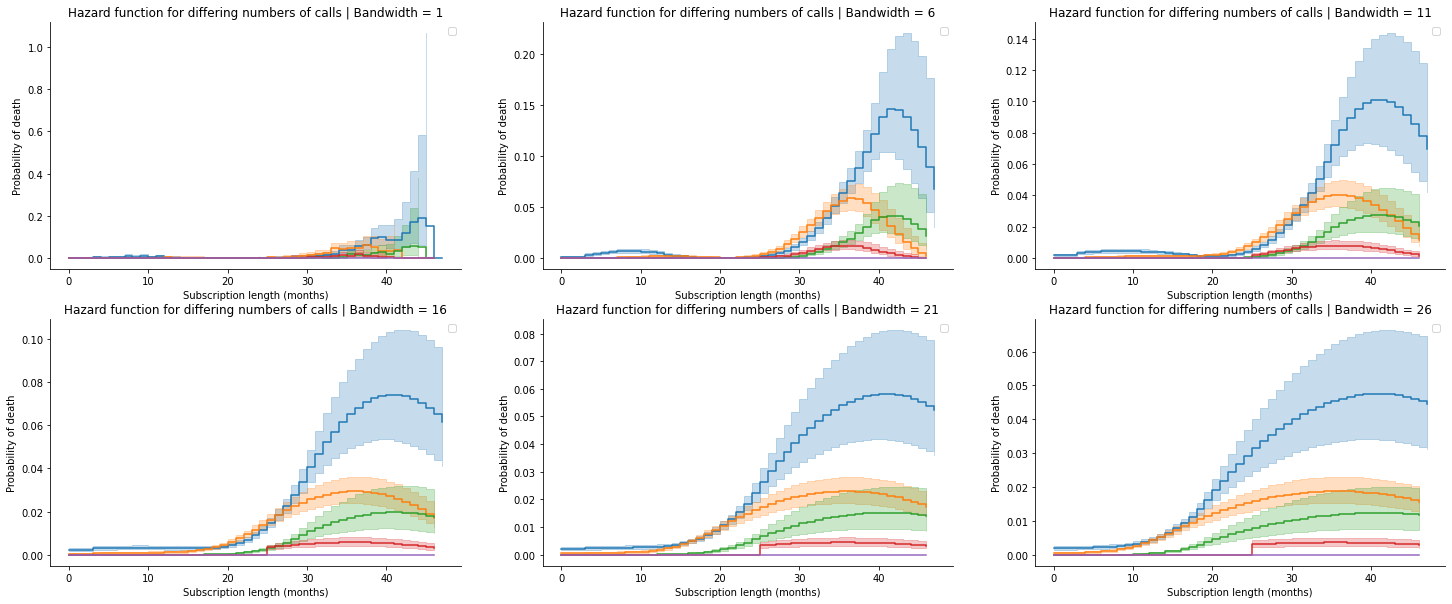

In [18]:
# set the plot dimensions
nrow = 2
ncol = 3

fig, axs = plt.subplots(nrow,ncol, figsize = (25,10))
legend = plt.legend()

# naf = NelsonAalenFitter()
# naf.fit(durations = df.SubscriptionLength[fou_dict['fou0']], event_observed = df.Churn[fou_dict['fou0']], 
#         label = "0 - lowest number of calls").plot_cumulative_hazard(ax = axs[0,0])
# naf.fit(durations = df.SubscriptionLength[fou_dict['fou1']], event_observed = df.Churn[fou_dict['fou1']], label = "1").plot_cumulative_hazard(ax = axs[0,0])
# naf.fit(durations = df.SubscriptionLength[fou_dict['fou2']], event_observed = df.Churn[fou_dict['fou2']], label = "2").plot_cumulative_hazard(ax = axs[0,0])
# naf.fit(durations = df.SubscriptionLength[fou_dict['fou3']], event_observed = df.Churn[fou_dict['fou3']], label = "3").plot_cumulative_hazard(ax = axs[0,0])
# naf.fit(durations = df.SubscriptionLength[fou_dict['fou4']], event_observed = df.Churn[fou_dict['fou4']], 
#         label = "4 - higher number of calls").plot_cumulative_hazard(ax = axs[0,0])

BANDWIDTH = 1
for row in range(nrow):
    for col in range(ncol):
        naf = NelsonAalenFitter()
        naf.fit(durations = df.SubscriptionLength[fou_dict['fou0']], event_observed = df.Churn[fou_dict['fou0']], 
                label = "0 - lowest number of calls").plot_hazard(bandwidth = BANDWIDTH, ax = axs[row,col], label = '_nolegend_')
        naf.fit(durations = df.SubscriptionLength[fou_dict['fou1']], event_observed = df.Churn[fou_dict['fou1']], 
                label = "1").plot_hazard(bandwidth = BANDWIDTH, ax = axs[row,col], label = '_nolegend_')
        naf.fit(durations = df.SubscriptionLength[fou_dict['fou2']], event_observed = df.Churn[fou_dict['fou2']], 
                label = "2").plot_hazard(bandwidth = BANDWIDTH, ax = axs[row,col], label = '_nolegend_')
        naf.fit(durations = df.SubscriptionLength[fou_dict['fou3']], event_observed = df.Churn[fou_dict['fou3']], 
                label = "3").plot_hazard(bandwidth = BANDWIDTH, ax = axs[row,col], label = '_nolegend_')
        naf.fit(durations = df.SubscriptionLength[fou_dict['fou4']], event_observed = df.Churn[fou_dict['fou4']], 
                label = "4 - higher number of calls").plot_hazard(bandwidth = BANDWIDTH, ax = axs[row,col], label = '_nolegend_')
        
        axs[row,col].set_xlabel("Subscription length (months)")
        axs[row,col].set_ylabel("Probability of death")
        axs[row,col].set_title("Hazard function for differing numbers of calls | Bandwidth = %.0f" % BANDWIDTH)
        axs[row,col].spines['right'].set_visible(False)
        axs[row,col].spines['top'].set_visible(False)
        
        BANDWIDTH += 5

### Weilbull Model

Another popular model for survival data is the Weibull model. In contrast to the two previous models seen thus far, this is a parametric model, which means that it has a functional form with parameters that the data is fitted to. The underlying distribution was actually applied to model particle size distributions, but it turned out that it models time-to-event data very well.

$$ S(t) = exp\left(-\left(\frac{t}{\lambda}\right)^\rho\right), \lambda\gt0, \rho\gt0 $$

where $\lambda$ determines the scale and $\rho$ determines the shape of the curve and:
- a value less than one indicates that the event rate decreases over time
- a value equal to one indicates that it remains constant over time and finally,
- a value greater than one indicates that the event rate increases over time.

In [19]:
wf = WeibullFitter()
wf.fit(durations = surv_df.SubscriptionLength, event_observed = surv_df.Churn)

wf.print_summary()

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 3150 total observations, 2655 right-censored observations>
   number of observations = 3150
number of events observed = 495
           log-likelihood = -2755.13
               hypothesis = lambda_ != 1, rho_ != 1

---
          coef   se(coef)   coef lower 95%   coef upper 95%
lambda_  55.07       1.05            53.01            57.13
rho_      4.10       0.16             3.78             4.42

          cmp to     z      p   -log2(p)
lambda_     1.00 51.51 <0.005        inf
rho_        1.00 18.95 <0.005     263.65
---
AIC = 5514.26

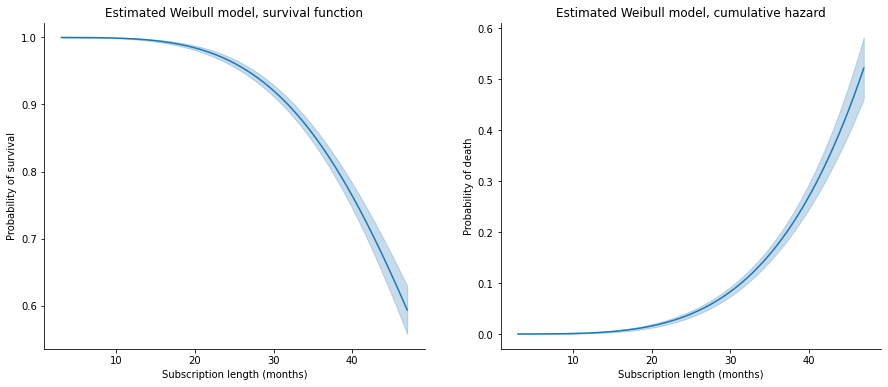

In [20]:
fig, axs = plt.subplots(1,2, figsize = (15,6))
wf.plot_survival_function(ax = axs[0])
wf.plot_cumulative_hazard(ax = axs[1])

axs[0].set_ylabel("Probability of survival")
axs[0].set_title("Estimated Weibull model, survival function")
axs[1].set_ylabel("Probability of death")
axs[1].set_title("Estimated Weibull model, cumulative hazard")

for col in range(2):
    axs[col].set_xlabel("Subscription length (months)")
    axs[col].legend_.remove()
    axs[col].spines['right'].set_visible(False)
    axs[col].spines['top'].set_visible(False)

Whilst the curve is similar, the biggest difference to observe between the Weibull model and the two previous models is the smoothness of the curves (compared to the step-type function).

And there's a whole range of other parametric models available to try, such as the exponential, log-normal, log-logistic, piecewise expontential, generalised gamma and spline models. Before we get to how we perform model selection, note that parametric models allow us to extrapolate the survival function beyond the maximum observed duration. For example, imagine that we wanted to know what happened to survival at 120 months (6 years).

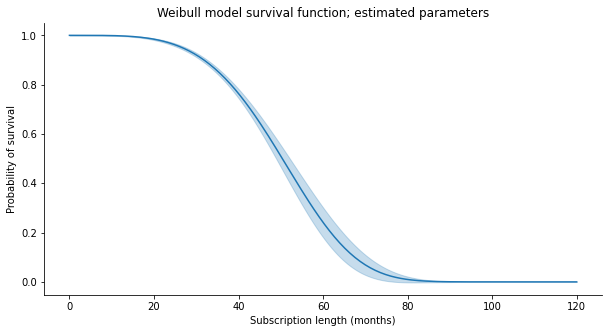

In [21]:
timeline = np.linspace(0, 120, 200)

wf = WeibullFitter().fit(durations = surv_df.SubscriptionLength, event_observed = surv_df.Churn)

wf.survival_function_at_times(timeline)
wf.hazard_at_times(timeline)
wf.cumulative_hazard_at_times(timeline)

wf = WeibullFitter().fit(durations = surv_df.SubscriptionLength, event_observed = surv_df.Churn, timeline = timeline)

# plot the extrapolated curve
fig, ax = plt.subplots(figsize = (10,5))
wf.plot_survival_function(ax = ax)
plt.xlabel("Subscription length (months)")
plt.ylabel("Probability of survival")
plt.title("Weibull model survival function; estimated parameters")
ax.legend_.remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Model Selection

Similar to a typical machine learning workflow, measures of fit are used to identify the most appropriate model to use when the underlying data generation distribution is unknown. These include QQ plots and tools such as the AIC.

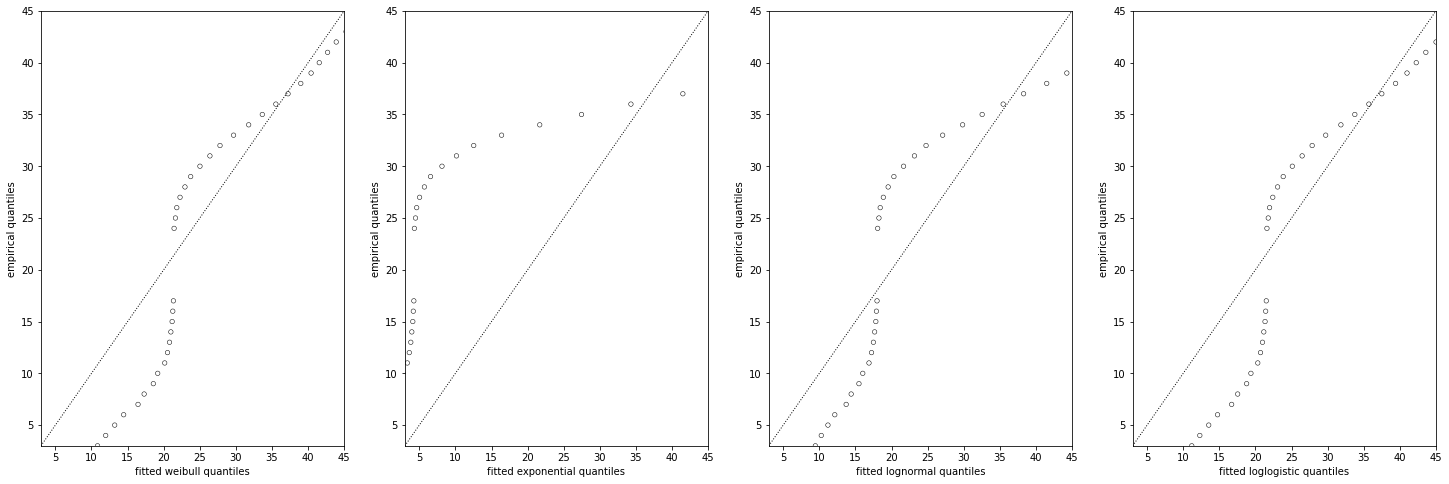

In [22]:
fig, axs = plt.subplots(1,4, figsize = (25,8))
axs = axs.reshape(4,)

for i, model in enumerate([WeibullFitter(), ExponentialFitter(), LogNormalFitter(), LogLogisticFitter()]):
    model.fit(durations = surv_df.SubscriptionLength, event_observed = surv_df.Churn)
    qq_plot(model, ax = axs[i])

Of the models for which a QQ plot can be generated, every single model is a bad fit for the data. That being said, the best out of the bunch are the Weibull and Log-logistic model as they deviate the least from the diagonal line.

The AIC is defined as: $$AIC(model) = -2ll + 2k$$

where $k$ is the number of parameters (degrees-of-freedom) of the model and $ll$ is the maximum log-likelihood. Recall that the model with the lowest AIC is desirable, since it's a tradeoff between maximising the log-likelihood using as few parameters as possible.

In [23]:
best_model, best_aic_ = find_best_parametric_model(event_times = surv_df.SubscriptionLength, event_observed = surv_df.Churn, scoring_method = "AIC")
print("Best model according to the AIC: ", best_model)
print("Best AIC score: ", best_aic_)

# we can also score the models using the BIC, but in this case it produces the same result
best_model, best_bic_ = find_best_parametric_model(event_times = surv_df.SubscriptionLength, event_observed = surv_df.Churn, scoring_method = "BIC")
print("Best model according to the BIC: ",best_model)
print("Best BIC score: ", best_bic_)

Best model according to the AIC:  <lifelines.PiecewiseExponentialFitter:"PiecewiseExponentialFitter: 3 breakpoint", fitted with 3150 total observations, 2655 right-censored observations>
Best AIC score:  5217.290266546979
Best model according to the BIC:  <lifelines.PiecewiseExponentialFitter:"PiecewiseExponentialFitter: 3 breakpoint", fitted with 3150 total observations, 2655 right-censored observations>
Best BIC score:  5241.510897474258


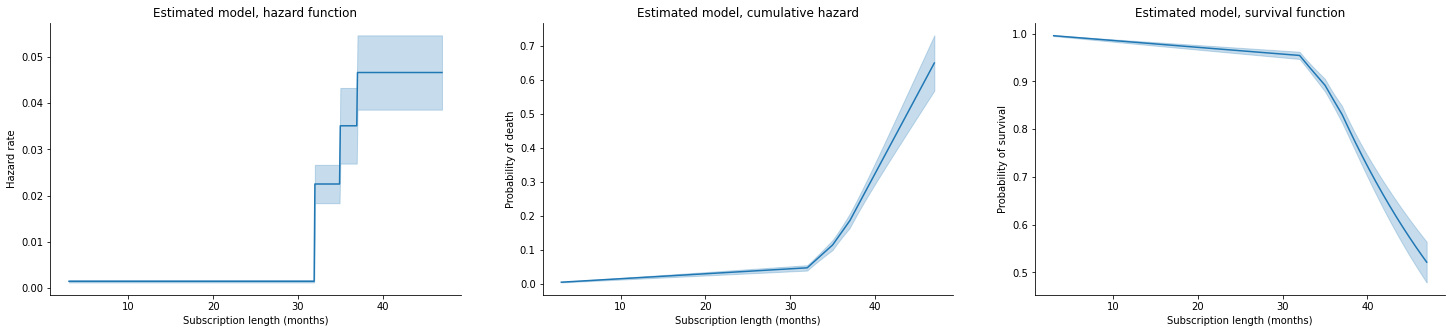

In [24]:
fig, axs = plt.subplots(1,3, figsize = (25,5))

best_model.plot_hazard(ax = axs[0])
best_model.plot_cumulative_hazard(ax = axs[1])
best_model.plot_survival_function(ax = axs[2])

axs[0].set_ylabel("Hazard rate")
axs[0].set_title("Estimated model, hazard function")
axs[1].set_ylabel("Probability of death")
axs[1].set_title("Estimated model, cumulative hazard")
axs[2].set_ylabel("Probability of survival")
axs[2].set_title("Estimated model, survival function")

for col in range(3):
    axs[col].set_xlabel("Subscription length (months)")
    axs[col].legend_.remove()
    axs[col].spines['right'].set_visible(False)
    axs[col].spines['top'].set_visible(False)

## Survival Regression

Survival regression refers to the use of covariates to help inform the estimation of survival rates in additional to the durations used thus far. Cox's proportional hazards model, accelerated failure models and Aalen's additive model are three popular models in this space.

All models attempt to represent the hazard rate $h(t|x)$ as a function of $t$ and one or more covariates $x$.

### Cox's Proportional Hazard Model

This is perhaps one of the more well-known hazard regression models and it expresses the log-hazard as a linear function of the covariates and a population-level baseline hazard that changes over time:

$$ \underbrace{h(t|x)}_\text{hazard} = b_0(t)\:\underbrace{exp\overbrace{\left(\sum_{i=1}^{n}b_i(x_i-\bar{x_i})\right)}^\text{log-partial hazard}}_\text{partial hazard} \approx b_0(t)\: exp(b_1x_1 + b_2x_2+\ldots+b_nx_n)$$

Note that the only *time* component is in the baseline hazard $b_0(t)$. The partial hazard is a *time-invariant* scalar factor that only increases or decreases the baseline hazard, which means that changes in the covariates will only inflate or deflate the baseline hazard (that is, $h_A(t) = ch_B(t)$). This is the proportional hazards assumption upon which the model is based.

Formulas can be used to create interactions, encode categorical variables, create basis splines, and so on. The formula interface is (almost) the same as what’s available in R and statsmodels. Also, `duration_col` is optional, but its absence leads the model to assume that all observations are uncensored.

In [25]:
cph = CoxPHFitter()
cph.fit(surv_df, duration_col = 'SubscriptionLength', event_col = 'Churn', formula = "CallFailure + Complains + ChargeAmount + SecondsofUse + FrequencyofUse + FrequencyofSMS \
        + DistinctCalledNumbers + TariffPlan + Status + Age + CustomerValue")

cph.print_summary(decimals = 3)

<lifelines.CoxPHFitter: fitted with 3150 total observations, 2655 right-censored observations>
             duration col = 'SubscriptionLength'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 3150
number of events observed = 495
   partial log-likelihood = -3054.962
         time fit was run = 2022-06-23 01:19:58 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
Age                   -0.012      0.988      0.009           -0.030            0.006                0.971                1.006
CallFailure            0.066      1.068      0.010            0.045            0.086                1.046                1.090
ChargeAmount          -0.279      0.756      0.093           -0.461           -0.098                0.631                0.907
Complains              1.802      6.059      0.110            1.587            2.016                4.888                7.511
CustomerValue          0.003      1.003      0.002           -0.001            0.008                0.999                1.008
DistinctCalledNumbers -0.019      0.981      0.008           -0.035           -0.003                0.965                0.997
FrequencyofSMS        -0.026      0.974      0.010           -0.045           -0.006                0.956                0.994
FrequencyofUse        -0.041      0.960      0.006           -0.052           -0.029                0.949                0.971
SecondsofUse           0.000      1.000      0.000           -0.000            0.000                1.000                1.000
Status                -0.105      0.900      0.158           -0.415            0.204                0.660                1.226
TariffPlan             1.021      2.777      0.446            0.147            1.896                1.158                6.660

                        cmp to      z       p   -log2(p)
covariate                                               
Age                      0.000 -1.322   0.186      2.425
CallFailure              0.000  6.294 <0.0005     31.591
ChargeAmount             0.000 -3.014   0.003      8.601
Complains                0.000 16.438 <0.0005    199.291
CustomerValue            0.000  1.458   0.145      2.788
DistinctCalledNumbers    0.000 -2.370   0.018      5.811
FrequencyofSMS           0.000 -2.597   0.009      6.734
FrequencyofUse           0.000 -6.897 <0.0005     37.459
SecondsofUse             0.000  0.841   0.400      1.321
Status                   0.000 -0.668   0.504      0.987
TariffPlan               0.000  2.288   0.022      5.499
---
Concordance = 0.877
Partial AIC = 6131.924
log-likelihood ratio test = 1084.326 on 11 df
-log2(p) of ll-ratio test = 747.002

#### Interpretation

$e^{coef}$ is the hazard ratio. A one unit increase in a continuous numeric covariate means the hazard changes by a factor of $e^{coef}$ or $(e^{coef}-1\times100)$% for the *average* individual. For example, a one unit increase in the frequence of usage by a customer means that a customer's risk of churning decreases by about 3.9%. Alternatively, a one unit increase in the frequency of call failures means that a customer's risk of churning increases by about 7.3%.

With respect to a binary covariate, a customer that complains is about 500% more likely to churn compared to one that doesn't, all else being equal.

In short, hazard ratios greater than one mean that the risk of the event occurring increases, hazard ratios less than one mean that the risk of the event occurring decreases and hazard ratios exactly equal to one imply no effect.

Correspondingly, we can also calculate the effect on survival time using: $\frac{1}{e^{coef}} (\times100$ to get the effect in percentage terms).

Observe that each coefficient also has a measure of statistical significance attached to it, like in a standard linear regression. And as per a standard regression, these indicate whether or not the model thinks the covariate has a statistically significant impact on the hazard risk independent of the size of the coefficient.

The plot below displays this visually, and indicates that only *Complains*, *TariffPlan*, and *ChargeAmount* have a clear impact on the risk of churning, whereas the remainder have either no impact (the range of values crosses 0) or the impact is minimal (the range of values is very close to zero, but doesn't cross) at the 95% confidence level.

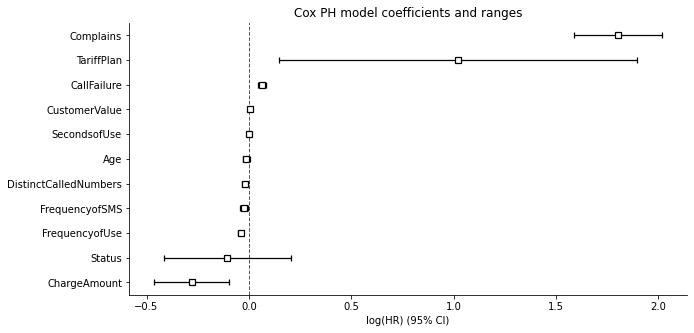

In [26]:
fig, ax = plt.subplots(figsize = (10,5))

cph.plot()
plt.title("Cox PH model coefficients and ranges")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

You're also able to visualise how the survival curve changes as the value of a covariate changes whilst holding everything else equal.

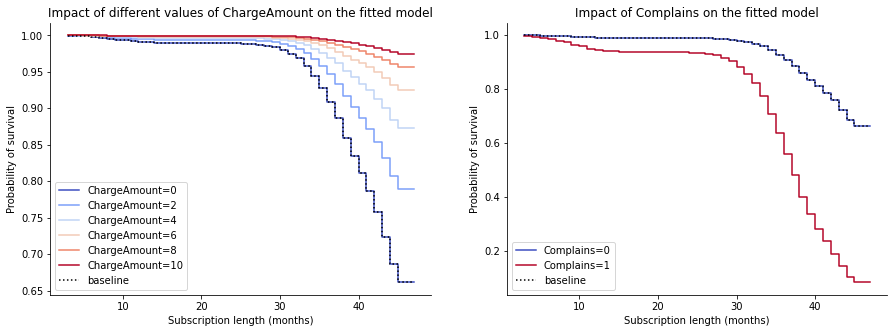

In [27]:
fig, axs = plt.subplots(1,2, figsize = (15,5))

cph.plot_partial_effects_on_outcome(covariates = 'ChargeAmount', values = [0, 2, 4, 6, 8, 10], cmap = 'coolwarm', ax = axs[0])
cph.plot_partial_effects_on_outcome(covariates = 'Complains', values = [0, 1], cmap = 'coolwarm', ax = axs[1])

axs[0].set_title("Impact of different values of ChargeAmount on the fitted model")
axs[1].set_title("Impact of Complains on the fitted model")

for col in range(2):
    axs[col].set_xlabel("Subscription length (months)")
    axs[col].set_ylabel("Probability of survival")
    axs[col].spines['right'].set_visible(False)
    axs[col].spines['top'].set_visible(False)

#### An aside: The baseline hazard

The baseline hazard is defined as the risk for individuals/subjects at the baseline levels of covariates. It does not mean that the values of the covariates are zero. This is an important concept because it's what the regression coefficient values are relative to. In the `lifelines`, package the baseline hazard is the median hazard for a specific covariate (or mode if the covariate is categorical).

The baseline hazard/survival can be viewed as per the figures below.

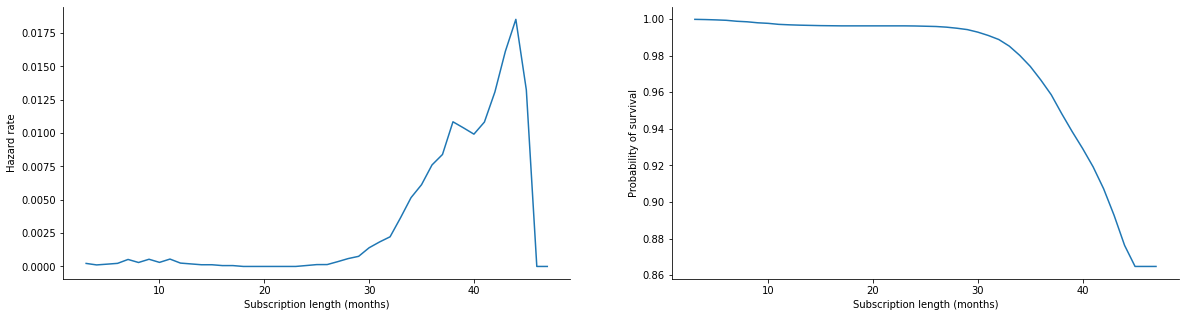

In [28]:
fig, axs = plt.subplots(1,2, figsize = (20,5))

cph.baseline_hazard_.plot(ax = axs[0])
cph.baseline_survival_.plot(ax = axs[1])

axs[0].set_ylabel("Hazard rate")
axs[1].set_ylabel("Probability of survival")

for col in range(2):
    axs[col].set_xlabel("Subscription length (months)")
    axs[col].legend_.remove()
    axs[col].spines['right'].set_visible(False)
    axs[col].spines['top'].set_visible(False)

#### Goodness of fit

There are several methods available for checking model quality/predictive performance:

1. Inspecting the survival probability calibration plot
2. Looking at the concordance-index as a measure of predictive accuracy
3. Looking at the likelihood test results
4. Checking the proportional hazards assumption
5. Examining model residuals

**Survival probability calibration plot**

This compares observed and expected probabilities against a specified time ($t_0$). According to the package author, use of a flexible spline regression model avoids the traditional problem of binning the continuous-valued probability and handles censored data.

- ICI - mean absolute difference between predicted and observed
- E50 - median absolute difference between predicted and observed

The plot below indicates that the model isn't a great fit to the data.

ICI =  0.02397695003965468
E50 =  0.010819467076619294


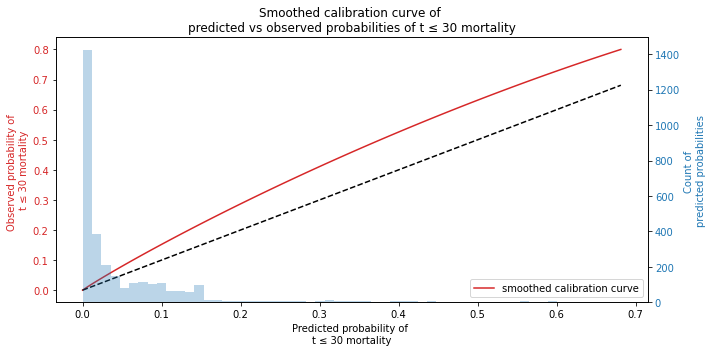

In [29]:
cph2 = CoxPHFitter(baseline_estimation_method = "spline", n_baseline_knots = 4)
cph2.fit(surv_df, duration_col = 'SubscriptionLength', event_col = 'Churn', formula = "CallFailure + Complains + ChargeAmount + SecondsofUse + FrequencyofUse + FrequencyofSMS \
         + DistinctCalledNumbers + TariffPlan + Status + Age + CustomerValue")

fig, axs = plt.subplots(figsize = (10,5))
survival_probability_calibration(cph2, surv_df, t0 = 30, ax = axs)
axs.legend(loc = 'lower right');

**Concordance index**

The concordance-index (c-index) evaluates the accuracy of the *ranking* of predicted time. It's also a generalisation of the AUC, and interpreted similarly. Typical models generally range between 0.55 and 0.75, which may appear bad but even a perfect model can contain enough noise to make a high/perfect score impossible. One final thing to note, the measure is scale and shift-invariant so a model maximised for the c-index wouldn't necessarily give good predicted times, but would give good predicted rankings.

In [30]:
print("C-index: ", round(cph.concordance_index_, 6))

C-index:  0.876934


**Proportional hazards assumption**

Recall that under this assumption, all subjects have the same hazard function separated by a scaler multiple, and this value is time-invariant. That is:

$$ h_i(t) = a_ih(t) $$ and $$ a_i(t) = a_i $$ and $$ \frac{h_i(t)}{h_j(t)} = \frac{a_ih(t)}{a_jh(t)} = \frac{a_i}{a_j} \:\text{is constant for all t.}$$


Depending on the purpose of the modelling, you may not need to actually care about whether this assumption is violated or not. This is particularly true in the case of prediction as you're more interested in maximising model accuracy rather than what's happening underneath/how exactly those predictions are being generated. On the other hand, if you're ultimate goal is inference, then you're very much going to care about whether this assumption holds or not.

The package author also argues that you should not change a model just to satisfy the assumptions behind that model, albeit being fully aware of the consequences of that decision with respect to things like model power and interpretation.

*Checking the assumption*

The `lifelines` package offers a convenient function to check the assumption at a specified significance value. It computes relevant statistics, suggests ways to correct the violates and produces a set of plots for each variable that violates the assumption. Some of the ways of fixing the violations include:
- stratification/splitting the dataset into different subsamples
- modifying the underlying functional form by including splines, quadratic or cubic terms
- binning a variable and then stratifying it, and
- introducing time-varying covariates.

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3150 total observations, 2655 right-censored observations>
         test_name = proportional_hazard_test

---
                            test_statistic      p  -log2(p)
Age                   km              6.21   0.01      6.30
                      rank           14.72 <0.005     12.97
CallFailure           km              7.57   0.01      7.39
                      rank            7.75   0.01      7.54
ChargeAmount          km             34.89 <0.005     28.09
                      rank           33.19 <0.005     26.83
Complains             km             21.97 <0.005     18.46
                      rank           36.81 <0.005     29.52
CustomerValue         km             10.19 <0.005      9.46
                      rank            4.35   0.04      4.75
DistinctCalledNumbers km             10.53 <0.005      9.73
                      rank           12.75 <0.005     11.46
FrequencyofSMS        km              9.09 <0.005      8.61
                      rank            3.46   0.06      3.99
FrequencyofUse        km              8.95 <0.005      8.49
                      rank            6.29   0.01      6.36
SecondsofUse          km             19.09 <0.005     16.29
                      rank           11.86 <0.005     10.77
Status                km              7.99 <0.005      7.73
                      rank           21.98 <0.005     18.47
TariffPlan            km              0.14   0.70      0.51
                      rank            0.19   0.66      0.60



1. Variable 'Age' failed the non-proportional test: p-value is 0.0001.

   Advice: with so few unique values (only 5), you can include `strata=['Age', ...]` in the call in
`.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'CallFailure' failed the non-proportional test: p-value is 0.0054.

   Advice 1: the functional form of the variable 'CallFailure' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'CallFailure' using pd.cut, and then specify it in
`strata=['CallFailure', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


3. Variable 'Cha

[[<AxesSubplot:xlabel='rank-transformed time\n(p=0.0001)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0127)'>],
 [<AxesSubplot:xlabel='rank-transformed time\n(p=0.0054)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0059)'>],
 [<AxesSubplot:xlabel='rank-transformed time\n(p=0.0000)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0000)'>],
 [<AxesSubplot:xlabel='rank-transformed time\n(p=0.0000)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0000)'>],
 [<AxesSubplot:xlabel='rank-transformed time\n(p=0.0371)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0014)'>],
 [<AxesSubplot:xlabel='rank-transformed time\n(p=0.0004)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0012)'>],
 [<AxesSubplot:xlabel='rank-transformed time\n(p=0.0630)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0026)'>],
 [<AxesSubplot:xlabel='rank-transformed time\n(p=0.0121)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0028)'>],
 [<AxesSubplot:xlabel='rank-transformed time\n(p

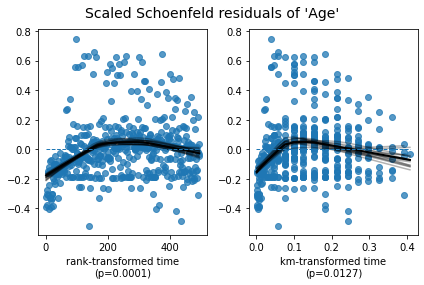

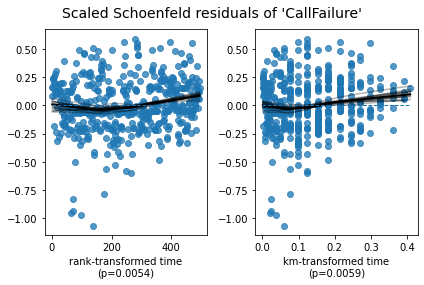

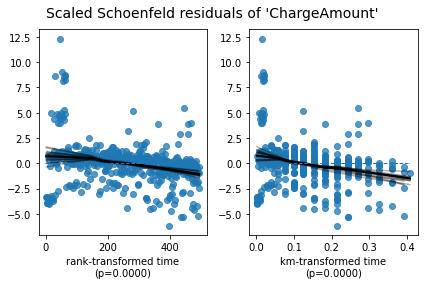

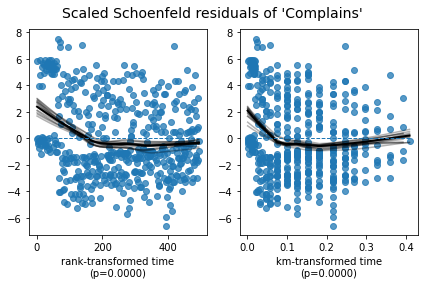

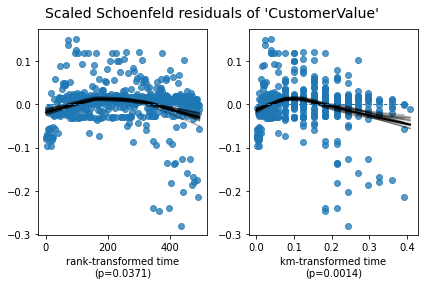

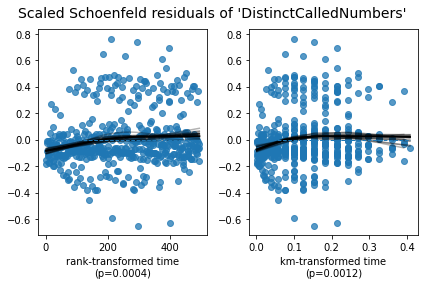

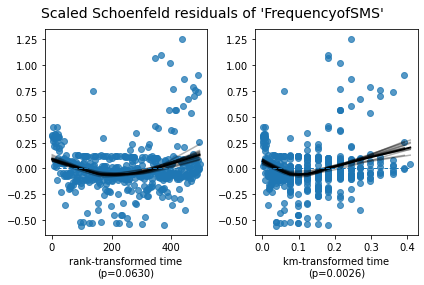

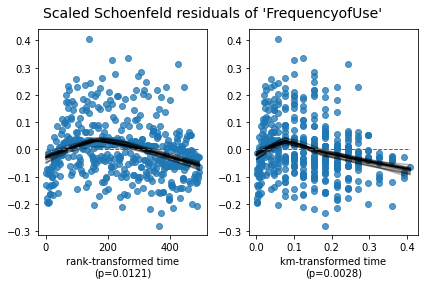

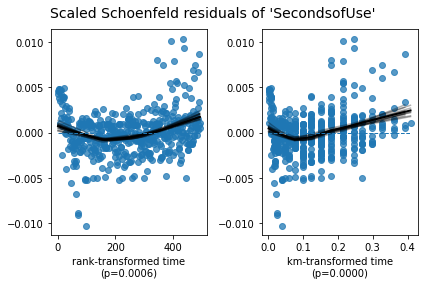

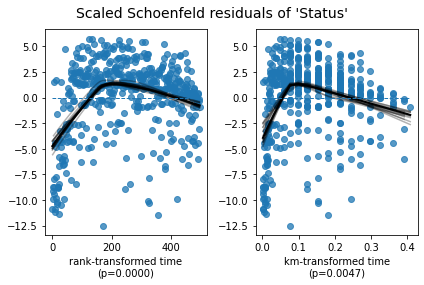

In [31]:
# there's a lot of output, hence why scrolling is enabled
cph.check_assumptions(surv_df, p_value_threshold = 0.05, show_plots = True)

**Model residuals**

As with linear regression, examining of model residuals can help diagnose poor fit to a dataset and/or improve the fit of a model, by providing useful modelling insights such as where non-linearities in the data have not been captured and where the assumption of proportional hazards has been violated.

There are six types of residuals available in the `lifelines` package:

- schoenfeld / scaled schoenfeld
- score
- delta_beta
- deviance, and
- martingale.

*Schoenfeld / scaled Schoenfeld residuals*

These residuals are slightly different from the rest of the list in that each residual corresponds to a variable rather than an observation. Furthermore, their primary purpose is to test the proportional hazards assumption. Essentially, the assumption can be visually assessed by plotting a LOESS curve through the data, with a residual value of 0 with a gradient of 0 (a straight flat line) indicating that the assumption is satisfied. These residuals are provided through the `check_assumptions` method attached to a fitted model.

*Martingale residuals*

Take a value between 1 and $-Inf$ for uncensored observations, and 0 and $-Inf$ for censored observations. Positive values mean the subject died sooner than expected and negative values mean the patient lived longer than expected (or were censored; according to the model). They can be used to assess the true functional form of a particular covariate.

*Deviance residuals*

One of the problems with martingale residuals are that they are asymmetric about 0. Deviance residuals are a transform of martingale residuals to render them symmetric. They have the same interpretation as martingale residuals, but very large or very small values are possible outliers.

*Score and Delta beta*

There is no information on these in the documentation AND they produce a matrix of NAs, so we'll skip them for now.

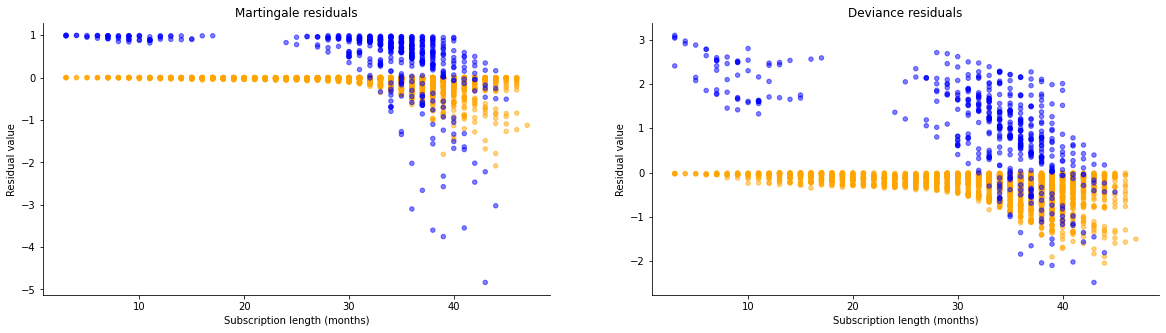

In [32]:
m_resids = cph.compute_residuals(surv_df, 'martingale')
d_resids = cph.compute_residuals(surv_df, 'deviance')

fig, axs = plt.subplots(1,2, figsize = (20,5))

m_resids.plot.scatter(x = 'SubscriptionLength', y = 'martingale', c = np.where(d_resids.Churn, "blue", "orange"), alpha = 0.5, ax = axs[0])
d_resids.plot.scatter(x = 'SubscriptionLength', y = 'deviance', c = np.where(d_resids.Churn, "blue", "orange"), alpha = 0.5, ax = axs[1])

axs[0].set_title("Martingale residuals")
axs[1].set_title("Deviance residuals")

for col in range(2):
    axs[col].set_xlabel("Subscription length (months)")
    axs[col].set_ylabel("Residual value")
    axs[col].spines['right'].set_visible(False)
    axs[col].spines['top'].set_visible(False)

#### Prediction

As with any model, once it has been fitted, it can be used for prediction. For example, one can predict the survival function, the median survival time or the partial hazard.

#### Modelling baseline hazard and survival with parametric models

If you may have suspected from the shape of the covariate plots, the Cox Proportional Hazards model is a semi-parametric model by default. This means that its baseline hazard $h_0(t)$ has no parametric form. However, in some circumstances you may wish to produce a parametric baseline, as these make survival predictions more efficient, allow for a better understanding of baseline behaviour and permit interpolation/extrapolation. In `lifelines`, a parametric baseline is obtained by using a cubic spline or piecewise constant hazard rather than the default Breslow method.

In [33]:
spline_cph = CoxPHFitter(baseline_estimation_method = "spline", n_baseline_knots = 3)
spline_cph.fit(surv_df, duration_col = 'SubscriptionLength', event_col = 'Churn', formula = "CallFailure + Complains + ChargeAmount + SecondsofUse + FrequencyofUse + FrequencyofSMS \
               + DistinctCalledNumbers + TariffPlan + Status + Age + CustomerValue")

spline_cph.print_summary(decimals = 3)

<lifelines.CoxPHFitter: fitted with 3150 total observations, 2655 right-censored observations>
             duration col = 'SubscriptionLength'
                event col = 'Churn'
 number of baseline knots = 3
      baseline estimation = spline
   number of observations = 3150
number of events observed = 495
           log-likelihood = -2113.517
         time fit was run = 2022-06-23 01:20:41 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param covariate                                                                                                                     
beta_ Intercept             -7.058      0.001      0.761           -8.550           -5.566                0.000                0.004
      Age                   -0.024      0.976      0.009           -0.041           -0.007                0.960                0.993
      CallFailure            0.063      1.065      0.010            0.043            0.083                1.044                1.087
      ChargeAmount          -0.305      0.737      0.089           -0.480           -0.130                0.619                0.878
      Complains              1.752      5.765      0.109            1.538            1.965                4.657                7.136
      CustomerValue         -0.001      0.999      0.002           -0.005            0.003                0.995                1.003
      DistinctCalledNumbers -0.020      0.980      0.008           -0.036           -0.005                0.965                0.995
      FrequencyofSMS        -0.009      0.991      0.009           -0.025            0.008                0.975                1.008
      FrequencyofUse        -0.039      0.962      0.006           -0.050           -0.028                0.951                0.973
      SecondsofUse           0.000      1.000      0.000            0.000            0.000                1.000                1.000
      Status                -0.236      0.790      0.153           -0.536            0.064                0.585                1.066
      TariffPlan             0.957      2.605      0.451            0.074            1.841                1.077                6.303
phi1_ Intercept              0.955      2.599      0.139            0.683            1.227                1.980                3.410
phi2_ Intercept             -4.873      0.008     14.290          -32.881           23.136                0.000            1.116e+10
phi3_ Intercept             -3.188      0.041     23.204          -48.666           42.291                0.000            2.326e+18

                              cmp to      z       p   -log2(p)
param covariate                                               
beta_ Intercept                0.000 -9.271 <0.0005     65.551
      Age                      0.000 -2.731   0.006      7.305
      CallFailure              0.000  6.105 <0.0005     29.857
      ChargeAmount             0.000 -3.418   0.001     10.629
      Complains                0.000 16.089 <0.0005    191.056
      CustomerValue            0.000 -0.289   0.772      0.373
      DistinctCalledNumbers    0.000 -2.559   0.010      6.576
      FrequencyofSMS           0.000 -1.016   0.309      1.692
      FrequencyofUse           0.000 -6.687 <0.0005     35.350
      SecondsofUse             0.000  2.243   0.025      5.329
      Status                   0.000 -1.540   0.123      3.018
      TariffPlan               0.000  2.124   0.034      4.892
phi1_ Intercept                0.000  6.884 <0.0005     37.319
phi2_ Intercept                0.000 -0.341   0.733      0.448
phi3_ Intercept                0.000 -0.137   0.891      0.167
---
AIC = 4257.034
log-likelihood ratio test = 1037.247 on 11 df
-log2(p) of ll-ratio test = 713.329

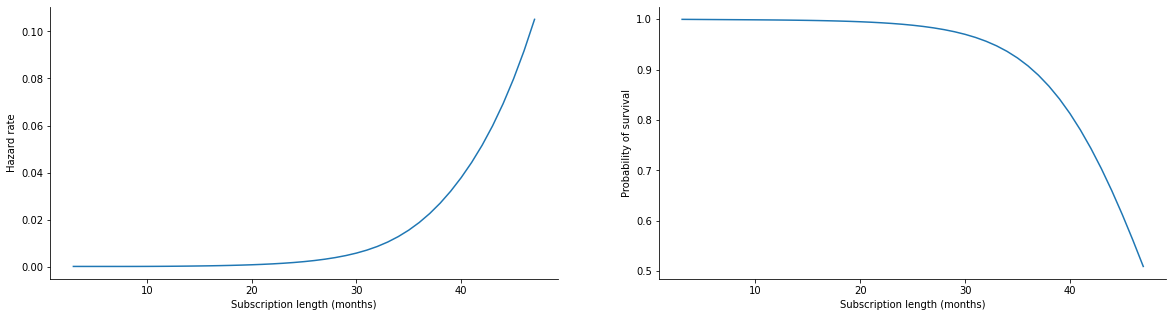

In [34]:
fig, axs = plt.subplots(1,2, figsize = (20,5))

spline_cph.baseline_hazard_.plot(ax = axs[0])
spline_cph.baseline_survival_.plot(ax = axs[1])

axs[0].set_ylabel("Hazard rate")
axs[1].set_ylabel("Probability of survival")

for col in range(2):
    axs[col].set_xlabel("Subscription length (months)")
    axs[col].legend_.remove()
    axs[col].spines['right'].set_visible(False)
    axs[col].spines['top'].set_visible(False)

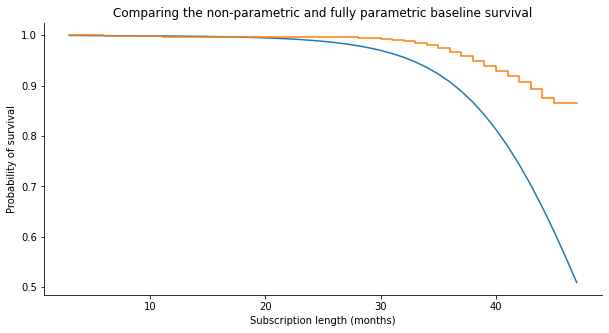

In [35]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)

spline_cph.baseline_survival_.plot(ax = ax)
cph.baseline_survival_.plot(ax = ax, drawstyle = "steps-post")

ax.set_xlabel("Subscription length (months)")
ax.set_ylabel("Probability of survival")
ax.set_title("Comparing the non-parametric and fully parametric baseline survival")
ax.legend_.remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Accelerated Failure Time (AFT) models

These are possibly the most common type of fully parametric survival models. The idea behind these models is that two populations with different survival functions are related by some *accelerated failure rate*, $\lambda$:

$$ S_A(t) = S_B\:\left(\frac{t}{\lambda}\right) $$

... which can be interpreted as slowing down or speeding up moving along the survival function. AFT models also have some nice properties such as the fact that the average (mean or median) survival time of population $B$ is $\lambda$ times the average survival time of population A.

The $\lambda$ can also be modelled as a function of the available covariates:

$$ S_A(t) = S_B\:\left(\frac{t}{\lambda(x)}\right) $$

$$\lambda(x) = exp\,\left(b_0 + \sum_{i=1}^nb_ix_i \right) $$

The model can accelerate or decelerate "death" times depending on the covariates. Another nice feature of this is the ease of coefficient interpretation: a unit increase in $x_i$ means the average/median survival time changes by a factor of $exp(b_i)$.

Note that how the sign influences event times in AFT models is the *opposite* to how it's done in the Cox Proportional Hazards model. That is, if $b_i$ is positive, then $exp(b_i) > 1$, which decelerates the event time since time is divided by the factor, which in turn increases average survival (and vice versa).

The survival function also needs a parametric form. The most common is the Weibull form, but other forms are also available, such as the log-normal, log-logistic, generalised gamma regression, spline-based and piecewise-exponential.

#### Weibull

Using the Weibull functional form, the hazard function is defined as:

$$ H(t;x) = \left(\frac{t}{\lambda(x)}\right)^\rho $$

In [36]:
w_aft = WeibullAFTFitter()
w_aft.fit(surv_df, duration_col = 'SubscriptionLength', event_col = 'Churn', formula = "CallFailure + Complains + ChargeAmount + SecondsofUse + FrequencyofUse + FrequencyofSMS \
               + DistinctCalledNumbers + TariffPlan + Status + Age + CustomerValue")

w_aft.print_summary(decimals = 3)

<lifelines.WeibullAFTFitter: fitted with 3150 total observations, 2655 right-censored observations>
             duration col = 'SubscriptionLength'
                event col = 'Churn'
   number of observations = 3150
number of events observed = 495
           log-likelihood = -2263.704
         time fit was run = 2022-06-23 01:20:55 UTC

---
                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                     
lambda_ Intercept              3.815     45.387      0.142            3.537            4.094               34.355               59.961
        Age                    0.003      1.003      0.002           -0.001            0.006                0.999                1.006
        CallFailure           -0.014      0.987      0.002           -0.018           -0.009                0.982                0.991
        ChargeAmount           0.040      1.040      0.020            0.001            0.079                1.001                1.082
        Complains             -0.372      0.690      0.028           -0.426           -0.317                0.653                0.728
        CustomerValue         -0.001      0.999      0.000           -0.002            0.000                0.998                1.000
        DistinctCalledNumbers  0.003      1.003      0.002           -0.000            0.006                1.000                1.006
        FrequencyofSMS         0.005      1.005      0.002            0.001            0.009                1.001                1.009
        FrequencyofUse         0.008      1.008      0.001            0.006            0.011                1.006                1.011
        SecondsofUse          -0.000      1.000      0.000           -0.000            0.000                1.000                1.000
        Status                -0.002      0.998      0.034           -0.069            0.066                0.933                1.068
        TariffPlan            -0.149      0.862      0.101           -0.346            0.048                0.707                1.050
rho_    Intercept              1.494      4.454      0.040            1.415            1.572                4.118                4.817

                                cmp to       z       p   -log2(p)
param   covariate                                                
lambda_ Intercept                0.000  26.852 <0.0005    525.169
        Age                      0.000   1.373   0.170      2.559
        CallFailure              0.000  -5.896 <0.0005     28.000
        ChargeAmount             0.000   1.986   0.047      4.409
        Complains                0.000 -13.364 <0.0005    132.913
        CustomerValue            0.000  -1.193   0.233      2.103
        DistinctCalledNumbers    0.000   1.764   0.078      3.684
        FrequencyofSMS           0.000   2.226   0.026      5.265
        FrequencyofUse           0.000   6.212 <0.0005     30.835
        SecondsofUse             0.000  -0.667   0.505      0.987
        Status                   0.000  -0.052   0.959      0.061
        TariffPlan               0.000  -1.479   0.139      2.845
rho_    Intercept                0.000  37.361 <0.0005   1012.422
---
Concordance = 0.876
AIC = 4553.409
log-likelihood ratio test = 982.852 on 11 df
-log2(p) of ll-ratio test = 674.441

These coefficients are interpreted the same way as before. For example, if a customer complains then his/her chance of not churning decreases by $exp^{-0.372} = 0.689 \approx 31$%. 

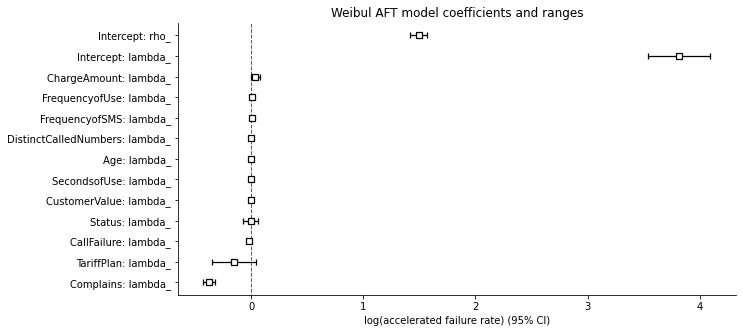

In [37]:
fig, ax = plt.subplots(figsize = (10,5))

w_aft.plot()
plt.title("Weibul AFT model coefficients and ranges")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

We are also able to model the unknown parameter $\rho$. What this does apparently is help in survival prediction by allowing heterogeneity in the $\rho$ parameter. However, by doing so the model is no longer an AFT model.

In [38]:
w_rho = WeibullAFTFitter()
w_rho.fit(surv_df, duration_col = 'SubscriptionLength', event_col = 'Churn', formula = "CallFailure + Complains + ChargeAmount + SecondsofUse + FrequencyofUse + FrequencyofSMS \
               + DistinctCalledNumbers + TariffPlan + Status + Age + CustomerValue", ancillary = True)

# w_rho.print_summary(decimals = 3)

<lifelines.WeibullAFTFitter: fitted with 3150 total observations, 2655 right-censored observations>

Also similar to the Cox PH model, we can observe how survival changes based on varying values of a covariate. It's also a good time to observe the effects of modelling $\rho$ versus keeping it fixed - i.e. it produces a more flexible set of survival functions.

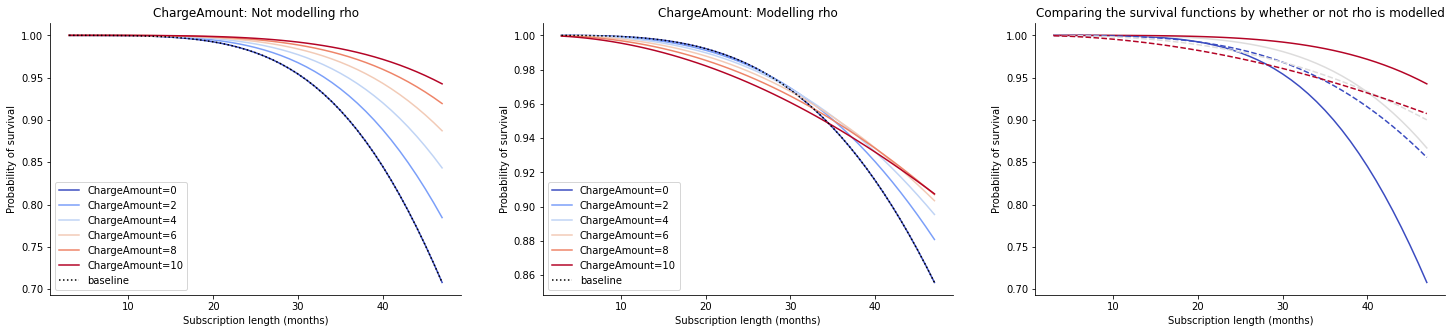

In [39]:
fig, axs = plt.subplots(1,3, figsize = (25,5))

w_aft.plot_partial_effects_on_outcome(covariates = 'ChargeAmount', values = [0, 2, 4, 6, 8, 10], cmap = 'coolwarm', ax = axs[0])
w_rho.plot_partial_effects_on_outcome(covariates = 'ChargeAmount', values = [0, 2, 4, 6, 8, 10], cmap = 'coolwarm', ax = axs[1])

w_aft.plot_partial_effects_on_outcome(covariates = 'ChargeAmount', values = [0, 5, 10], cmap = 'coolwarm', ax = axs[2], plot_baseline = False)
w_rho.plot_partial_effects_on_outcome(covariates = 'ChargeAmount', values = [0, 5, 10], cmap = 'coolwarm', ax = axs[2], ls = '--', plot_baseline = False)

axs[0].set_title("ChargeAmount: Not modelling rho")
axs[1].set_title("ChargeAmount: Modelling rho")
axs[2].set_title("Comparing the survival functions by whether or not rho is modelled")

axs[2].get_legend().remove()

for col in range(3):
    axs[col].set_xlabel("Subscription length (months)")
    axs[col].set_ylabel("Probability of survival")
    axs[col].spines['right'].set_visible(False)
    axs[col].spines['top'].set_visible(False)

Similar to the Cox Proportional Hazards model, there are prediction functions available to analyse the future survival of new observations. If the ancillary covariates have been modelled, then values for these need to be supplied.

In addition, it is often of interest to predict the event time of censored subjects - in this case predict when customers might be likely to churn. This is equivalent to asking the question *What is a subject's new survival function given that the subject has survived past time $s$?*:

$$ P(T > t | T > s) = \frac{P(T > t\:\text{and}\:T > s)}{P(T > s)} = \frac{P(T > t}{P(T > s)} = \frac{S(t)}{S(s)} $$

where $T$ is the (random) event time for an observation, and $P(t) := P(T > t)$ is its survival function.

Note that this computes a conditional probability or metric, so if the result of `predict_median` is 20.25 as per the first observation, then the entire lifetime is: $20.25 + \text{conditional_after} = 20.25 + 38 = 58.25\:\text{months}$. If `conditional_after` is being used to predict uncensored subjects, then it should be set to 0 or left blank.

In [40]:
# the model used here is the vanilla Weibull AFT model (without modelling rho)
# filter down to just the censored subjects to predict survival
censored_subjects = surv_df.loc[~surv_df.Churn.astype(bool)]
censored_subjects_last_obs = censored_subjects.SubscriptionLength

# predict new survival function
w_aft.predict_survival_function(censored_subjects, conditional_after = censored_subjects_last_obs)

# predict median remaining life
w_aft.predict_median(censored_subjects, conditional_after = censored_subjects_last_obs)

0        20.252928
1         7.458487
2        89.129622
3        15.925819
4        21.142934
           ...    
3144     30.655344
3145     74.950174
3146    163.905415
3147     41.928782
3148     70.048630
Length: 2655, dtype: float64

### Model Selection

If it is unclear as to which parametric model may fit the data best, then a simple and quick solution is to select the fitted model with the smallest AIC. In case this, it appears as though the best model is the Weibull model with a modelled $\rho$.

In [41]:
data = surv_df
duration = 'SubscriptionLength'
event = 'Churn'
formula = "CallFailure + Complains + ChargeAmount + SecondsofUse + FrequencyofUse + FrequencyofSMS + DistinctCalledNumbers + TariffPlan + Status + Age + CustomerValue"

cph = cph.fit(data, duration_col = duration, event_col = event, formula = formula)

llf = LogLogisticAFTFitter().fit(data, duration_col = duration, event_col = event, formula = formula)
lnf = LogNormalAFTFitter().fit(data, duration_col = duration, event_col = event, formula = formula)
wf = WeibullAFTFitter().fit(data, duration_col = duration, event_col = event, formula = formula)

llf_rho = LogLogisticAFTFitter().fit(data, duration_col = duration, event_col = event, formula = formula, ancillary = True)
lnf_rho = LogNormalAFTFitter().fit(data, duration_col = duration, event_col = event, formula = formula, ancillary = True)
wf_rho = WeibullAFTFitter().fit(data, duration_col = duration, event_col = event, formula = formula, ancillary = True)

for model in [cph, llf, lnf, wf, llf_rho, lnf_rho, wf_rho]:
    try:
        print(round(model.AIC_, 4))
    except:
        print(round(model.AIC_partial_, 4))

6131.9239
4669.0715
4827.592
4553.4088
4015.9394
4051.88
3974.1772


### Aalen's Additive Model

Like the Cox Proportional Hazards model, this type of regression model defines the hazard rate. However, it's an additive rather than multiplicative model:

$$ h(t|x) = b_0(t) + b_1(t)x_1 + \ldots + b_N(t)x_N $$

Importantly, inference does not typically estimate the individual $b_i(t)$ coefficient values, but instead estimates $\int_{0}^tb_i(s)\,ds$. It's very important to remember this when interpreting model plots.

The author notes that during the estimation process, a linear regression is computed at each step and often this can be unstable due to high co-linearity or small sample sizes. A penaliser term controls the stability and its recommended that a small penaliser term is always included. The value of this term can be increased if model estimates remain unstable.

In [42]:
aaf = AalenAdditiveFitter(coef_penalizer = 0.1, fit_intercept = False)
aaf.fit(surv_df, duration_col = 'SubscriptionLength', event_col = 'Churn', formula = "CallFailure + Complains + ChargeAmount + SecondsofUse + FrequencyofUse + FrequencyofSMS + \
        DistinctCalledNumbers + TariffPlan + Status + Age + CustomerValue")

aaf.print_summary(decimals = 4)

<lifelines.AalenAdditiveFitter: fitted with 3150 total observations, 2655 right-censored observations>
             duration col = 'SubscriptionLength'
                event col = 'Churn'
           coef penalizer = 0.1
       number of subjects = 3150
number of events observed = 495
         time fit was run = 2022-06-23 01:22:17 UTC

---
Empty DataFrame
Columns: []
Index: [Intercept, Age, CallFailure, ChargeAmount, Complains, CustomerValue, DistinctCalledNumbers, FrequencyofSMS, FrequencyofUse, SecondsofUse, Status, TariffPlan]
---
Concordance = 0.4979

After fitting, the instance exposes a `cumulative_hazards_` DataFrame containing the estimates of $\int_{0}^tb_i(s)\,ds$:

In [43]:
aaf.cumulative_hazards_.head()

covariate,Intercept,Age,CallFailure,ChargeAmount,Complains,CustomerValue,DistinctCalledNumbers,FrequencyofSMS,FrequencyofUse,SecondsofUse,Status,TariffPlan
3.0,0.018247,-0.000206,-0.000023,-0.000507,0.004821,-0.000013,-0.000074,0.000041,-0.000065,0.000001,-0.006222,0.001490
4.0,0.026503,-0.000306,0.000022,-0.000986,0.004591,-0.000020,-0.000092,0.000061,-0.000118,0.000002,-0.009055,0.002707
5.0,0.034616,-0.000379,-0.000032,-0.001266,0.013638,-0.000025,-0.000147,0.000076,-0.000154,0.000003,-0.011958,0.003455
6.0,0.050909,-0.000512,-0.000028,-0.001489,0.018363,-0.000032,-0.000217,0.000094,-0.000221,0.000004,-0.017988,0.004197
7.0,0.086774,-0.000892,-0.000357,-0.001186,0.038144,-0.000052,-0.000342,0.000153,-0.000298,0.000005,-0.029106,0.004339


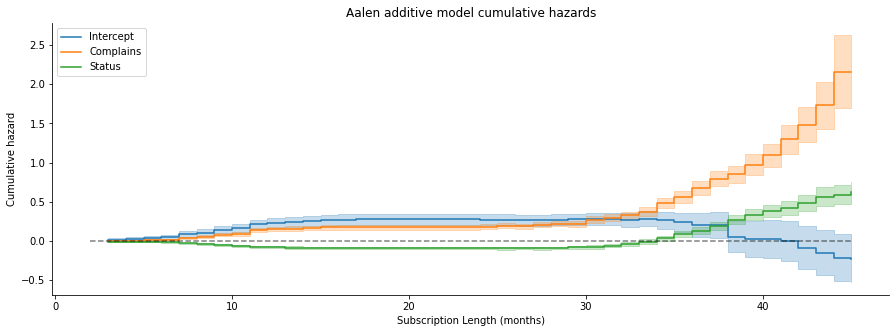

In [44]:
fig, ax = plt.subplots(figsize = (15,5))

aaf.plot(columns = ['Intercept', 'Complains', 'Status'])
plt.title("Aalen additive model cumulative hazards")
ax.set_xlabel("Subscription Length (months)")
ax.set_ylabel("Cumulative hazard")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

And that's all folks. Note that this has only touched the surface of what's possible. There are lots of little tweaks that could be done to the models to make them better, including exploration into building customised models and further extensions into the prediction functionality.